# CA-CRNN: Emotion Recognition from EEG Signals with 4D Features

This notebook implements the CA-CRNN model for EEG-based emotion recognition as described in the paper:
"Emotion recognition of EEG signals based on CA-CRNN with 4D features" by Zhang et al. (2025)

## Key Components:
- 4D Feature Structure (Frequency × Spatial × Temporal)
- Channel Attention Mechanism
- Convolutional Recurrent Neural Network (CRNN)
- Bidirectional LSTM for temporal feature extraction

## Datasets:
- DEAP (Valence/Arousal classification)
- SEED & SEED-IV (3-class emotion classification)
- GAMEEMO (Custom gaming emotion dataset)

In [53]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.io import loadmat
import pickle
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                      Flatten, BatchNormalization, LSTM, 
                                      Bidirectional, TimeDistributed, GlobalAveragePooling2D,
                                      GlobalMaxPooling2D, Reshape, Multiply, Add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Configuration and Setup

In [72]:
# Configuration
class Config:
    # Paths (Kaggle environment)
    DEAP_PATH = '/kaggle/input/deap-dataset/deap-dataset/data_preprocessed_python'
    SEED_IV_PATH = '/kaggle/input/seed-iv'
    GAMEEMO_PATH = '/kaggle/input/database-for-emotion-recognition-system-gameemo/GAMEEMO'
    
    # Output paths
    OUTPUT_DIR = './output'
    CHECKPOINT_DIR = './checkpoints'
    VISUALIZATIONS_DIR = './visualizations'
    GDRIVE_DIR = './gdrive_backup'
    
    # EEG Parameters
    SAMPLING_RATE_DEAP = 128  # Hz (preprocessed)
    SAMPLING_RATE_SEED = 200  # Hz
    WINDOW_SIZE = 0.5  # seconds
    
    # Frequency Bands
    FREQ_BANDS = {
        'theta': (4, 7),
        'alpha': (8, 13),
        'beta': (14, 30),
        'gamma': (31, 45)
    }
    
    # Model Parameters
    TIME_STEPS = 4  # Best result from paper (T=4)
    BATCH_SIZE = 128
    EPOCHS = 100
    LEARNING_RATE = 0.001
    N_FOLDS = 5
    
    # DEAP specific
    N_CHANNELS_DEAP = 32
    VALENCE_THRESHOLD = 5
    AROUSAL_THRESHOLD = 5
    
    # SEED-IV specific
    N_CHANNELS_SEED = 62
    N_CLASSES_SEED_IV = 4  # neutral, sad, fear, happy
    
    # Feature map dimensions (after electrode mapping)
    FEATURE_HEIGHT = 8
    FEATURE_WIDTH = 9
    N_FREQ_BANDS = 4

config = Config()

# Create directories
for directory in [config.OUTPUT_DIR, config.CHECKPOINT_DIR, 
                  config.VISUALIZATIONS_DIR, config.GDRIVE_DIR]:
    os.makedirs(directory, exist_ok=True)
    
print("Configuration loaded successfully!")
print(f"Output Directory: {config.OUTPUT_DIR}")
print(f"Checkpoint Directory: {config.CHECKPOINT_DIR}")


Configuration loaded successfully!
Output Directory: ./output
Checkpoint Directory: ./checkpoints


## 4D Feature Extraction

Implementation of the 4D feature structure that integrates:
- **Frequency information**: 4 frequency bands (θ, α, β, γ)
- **Spatial information**: 2D electrode mapping (8×9 grid)
- **Temporal information**: Time segments with differential entropy features

In [73]:
class EEGFeatureExtractor:
    """
    Extract 4D features from EEG signals according to the paper.
    4D structure: N × Frequency × Height × Width × TimeSteps
    """
    
    def __init__(self, sampling_rate=128, window_size=0.5, n_channels=32):
        self.sampling_rate = sampling_rate
        self.window_size = window_size
        self.n_samples_per_window = int(sampling_rate * window_size)
        self.n_channels = n_channels
        
        # 10-20 electrode mapping for DEAP (32 channels) to 8×9 grid
        self.electrode_mapping_deap = self._create_electrode_mapping_deap()
        
        # SEED electrode mapping (62 channels)
        self.electrode_mapping_seed = self._create_electrode_mapping_seed()
    
    def _create_electrode_mapping_deap(self):
        """
        Map 32 DEAP channels to 8×9 2D grid following 10-20 international system.
        Channels in DEAP: 
        Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1,
        Oz, Pz, Fp2, AF4, Fz, F4, F8, FC6, FC2, Cz, C4, T8, CP6, CP2, P4, P8, PO4, O2
        """
        mapping = np.zeros((8, 9), dtype=int) - 1  # -1 indicates no electrode
        
        # Map each channel to grid position (row, col)
        positions = {
            0: (0, 2), 1: (1, 2), 2: (2, 2), 3: (2, 0), 4: (3, 1), 5: (3, 3),
            6: (4, 2), 7: (4, 0), 8: (5, 1), 9: (5, 3), 10: (6, 2), 11: (6, 0),
            12: (7, 1), 13: (7, 2), 14: (7, 4), 15: (6, 4), 16: (0, 6), 17: (1, 6),
            18: (2, 4), 19: (2, 6), 20: (2, 8), 21: (3, 7), 22: (3, 5), 23: (4, 4),
            24: (4, 6), 25: (4, 8), 26: (5, 7), 27: (5, 5), 28: (6, 6), 29: (6, 8),
            30: (7, 7), 31: (7, 6)
        }
        
        for ch, (row, col) in positions.items():
            mapping[row, col] = ch
            
        return mapping
    
    def _create_electrode_mapping_seed(self):
        """
        Map 62 SEED channels to larger 2D grid.
        For SEED, we'll create a 9×9 grid to accommodate more electrodes.
        """
        mapping = np.zeros((9, 9), dtype=int) - 1
        
        # Simplified mapping for SEED (62 channels)
        # This is a simplified version; actual mapping should follow ESI-62 cap layout
        channel_idx = 0
        for i in range(9):
            for j in range(9):
                if channel_idx < 62:
                    mapping[i, j] = channel_idx
                    channel_idx += 1
                    
        return mapping[:8, :]  # Trim to 8×9 for consistency
    
    def differential_entropy(self, signal_segment):
        """
        Calculate Differential Entropy (DE) for a signal segment.
        DE = 0.5 * log(2πeσ²)
        
        Args:
            signal_segment: 1D array of EEG signal
            
        Returns:
            Differential entropy value
        """
        variance = np.var(signal_segment)
        if variance == 0:
            variance = 1e-10  # Avoid log(0)
        de = 0.5 * np.log(2 * np.pi * np.e * variance)
        return de
    
    def extract_frequency_bands(self, eeg_data):
        """
        Decompose EEG signal into frequency bands using Butterworth filter.
        
        Args:
            eeg_data: (n_samples, n_channels) EEG data
            
        Returns:
            Dictionary with frequency bands as keys and filtered signals as values
        """
        # Check if data is too short for filtering
        min_length = 30  # Minimum samples required for 4th order filter
        if eeg_data.shape[0] < min_length:
            raise ValueError(f"EEG data too short ({eeg_data.shape[0]} samples). "
                           f"Need at least {min_length} samples for filtering. "
                           f"This segment will be skipped.")
        
        frequency_data = {}
        
        for band_name, (low_freq, high_freq) in config.FREQ_BANDS.items():
            # Design Butterworth bandpass filter
            nyquist = self.sampling_rate / 2
            low = low_freq / nyquist
            high = high_freq / nyquist
            
            # Ensure frequencies are in valid range
            low = max(0.001, min(low, 0.999))
            high = max(0.001, min(high, 0.999))
            
            if low >= high:
                continue
                
            b, a = signal.butter(4, [low, high], btype='band')
            
            # Calculate minimum required length for filtfilt
            padlen = 3 * max(len(a), len(b))
            
            # Apply filter to each channel
            filtered_data = np.zeros_like(eeg_data)
            for ch in range(eeg_data.shape[1]):
                # Check if signal is long enough
                if eeg_data.shape[0] <= padlen:
                    # Signal too short, use unfiltered data with warning
                    filtered_data[:, ch] = eeg_data[:, ch]
                else:
                    # Apply filter normally
                    filtered_data[:, ch] = signal.filtfilt(b, a, eeg_data[:, ch])
            
            frequency_data[band_name] = filtered_data
            
        return frequency_data
    
    def extract_de_features(self, frequency_data):
        """
        Extract Differential Entropy features from frequency band data.
        
        Args:
            frequency_data: Dict of frequency bands with filtered signals
            
        Returns:
            DE features array (n_windows, n_bands, n_channels)
        """
        n_channels = list(frequency_data.values())[0].shape[1]
        n_samples = list(frequency_data.values())[0].shape[0]
        n_windows = n_samples // self.n_samples_per_window
        
        de_features = []
        
        for band_name in ['theta', 'alpha', 'beta', 'gamma']:
            if band_name not in frequency_data:
                continue
                
            band_data = frequency_data[band_name]
            band_de = np.zeros((n_windows, n_channels))
            
            for win in range(n_windows):
                start_idx = win * self.n_samples_per_window
                end_idx = start_idx + self.n_samples_per_window
                
                for ch in range(n_channels):
                    segment = band_data[start_idx:end_idx, ch]
                    band_de[win, ch] = self.differential_entropy(segment)
            
            de_features.append(band_de)
        
        # Stack: (n_windows, n_bands, n_channels)
        de_features = np.stack(de_features, axis=1)
        return de_features
    
    def map_to_2d(self, de_features, dataset='deap'):
        """
        Map 1D channel features to 2D spatial grid.
        
        Args:
            de_features: (n_windows, n_bands, n_channels)
            dataset: 'deap' or 'seed'
            
        Returns:
            2D mapped features (n_windows, n_bands, height, width)
        """
        mapping = self.electrode_mapping_deap if dataset == 'deap' else self.electrode_mapping_seed
        height, width = mapping.shape
        
        n_windows, n_bands, n_channels = de_features.shape
        
        features_2d = np.zeros((n_windows, n_bands, height, width))
        
        for win in range(n_windows):
            for band in range(n_bands):
                for i in range(height):
                    for j in range(width):
                        ch_idx = mapping[i, j]
                        if ch_idx >= 0 and ch_idx < n_channels:
                            features_2d[win, band, i, j] = de_features[win, band, ch_idx]
        
        return features_2d
    
    def create_4d_features(self, eeg_data, time_steps=4, dataset='deap'):
        """
        Create 4D feature structure from raw EEG data.
        
        Args:
            eeg_data: (n_samples, n_channels) raw EEG data
            time_steps: Number of consecutive time windows to combine
            dataset: 'deap' or 'seed'
            
        Returns:
            4D features (n_segments, n_bands, height, width, 2*time_steps)
        """
        # Step 1: Extract frequency bands
        frequency_data = self.extract_frequency_bands(eeg_data)
        
        # Step 2: Extract DE features
        de_features = self.extract_de_features(frequency_data)
        
        # Step 3: Map to 2D
        features_2d = self.map_to_2d(de_features, dataset=dataset)
        
        # Step 4: Create temporal structure (combine time_steps)
        n_windows, n_bands, height, width = features_2d.shape
        n_segments = n_windows - 2 * time_steps + 1
        
        if n_segments <= 0:
            # Not enough windows, return what we have
            features_4d = features_2d[:, :, :, :, np.newaxis]
            return features_4d
        
        features_4d = []
        for i in range(n_segments):
            # Concatenate 2*time_steps consecutive windows
            temporal_segment = features_2d[i:i+2*time_steps]
            # Reshape to (n_bands, height, width, 2*time_steps)
            temporal_segment = np.transpose(temporal_segment, (1, 2, 3, 0))
            features_4d.append(temporal_segment)
        
        features_4d = np.array(features_4d)
        return features_4d

print("4D Feature Extractor implemented successfully!")

4D Feature Extractor implemented successfully!


## Channel Attention Mechanism

Implementation of the Channel Attention (CA) module to emphasize important feature channels and suppress less relevant information.

In [74]:
class ChannelAttention(layers.Layer):
    """
    Channel Attention mechanism for EEG feature maps.
    
    Uses both average and max pooling to capture channel-wise statistics,
    then learns attention weights through a shared MLP.
    """
    
    def __init__(self, reduction_ratio=16, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
    
    def build(self, input_shape):
        channels = input_shape[-1]
        self.shared_dense_1 = Dense(
            channels // self.reduction_ratio,
            activation='relu',
            kernel_initializer='he_normal',
            use_bias=True,
            bias_initializer='zeros'
        )
        self.shared_dense_2 = Dense(
            channels,
            kernel_initializer='he_normal',
            use_bias=True,
            bias_initializer='zeros'
        )
        super(ChannelAttention, self).build(input_shape)
    
    def call(self, inputs):
        # Global Average Pooling
        avg_pool = GlobalAveragePooling2D()(inputs)
        avg_pool = Reshape((1, 1, avg_pool.shape[-1]))(avg_pool)
        
        # Global Max Pooling
        max_pool = GlobalMaxPooling2D()(inputs)
        max_pool = Reshape((1, 1, max_pool.shape[-1]))(max_pool)
        
        # Shared MLP
        avg_out = self.shared_dense_2(self.shared_dense_1(avg_pool))
        max_out = self.shared_dense_2(self.shared_dense_1(max_pool))
        
        # Combine and apply sigmoid
        attention = tf.nn.sigmoid(avg_out + max_out)
        
        # Apply attention weights
        return inputs * attention
    
    def get_config(self):
        config = super(ChannelAttention, self).get_config()
        config.update({'reduction_ratio': self.reduction_ratio})
        return config

print("Channel Attention mechanism implemented!")

Channel Attention mechanism implemented!


## CA-CRNN Model Architecture

Complete implementation of the CA-CRNN model combining:
- CNN layers with Channel Attention for spatial-frequency feature extraction
- BiLSTM for temporal feature learning
- Fully connected layers for classification

In [75]:
def build_ca_crnn_model(input_shape, n_classes=2, time_steps=4):
    """
    Build CA-CRNN model for EEG emotion recognition.
    
    Args:
        input_shape: (n_bands, height, width, 2*time_steps)
        n_classes: Number of output classes
        time_steps: Number of time steps (T)
        
    Returns:
        Keras model
    """
    
    # Input layer
    inputs = layers.Input(shape=input_shape, name='input_4d_features')
    
    # Process each time slice through CNN
    # TimeDistributed wrapper applies CNN to each time slice
    n_bands, height, width, temporal_length = input_shape
    
    # Reshape for processing: (batch, temporal, bands, h, w)
    x = layers.Permute((4, 1, 2, 3))(inputs)  # Move temporal to second dimension
    
    # Define CNN module for each time slice
    def cnn_module(x_slice):
        """CNN module with Channel Attention"""
        # Conv Layer 1: 64 filters, 5x5
        conv1 = Conv2D(64, (5, 5), padding='same', activation='relu', 
                       kernel_initializer='he_normal')(x_slice)
        conv1 = BatchNormalization()(conv1)
        conv1 = ChannelAttention(reduction_ratio=4)(conv1)
        
        # Conv Layer 2: 128 filters, 4x4
        conv2 = Conv2D(128, (4, 4), padding='same', activation='relu',
                       kernel_initializer='he_normal')(conv1)
        conv2 = BatchNormalization()(conv2)
        conv2 = ChannelAttention(reduction_ratio=8)(conv2)
        
        # Conv Layer 3: 256 filters, 4x4
        conv3 = Conv2D(256, (4, 4), padding='same', activation='relu',
                       kernel_initializer='he_normal')(conv2)
        conv3 = BatchNormalization()(conv3)
        conv3 = ChannelAttention(reduction_ratio=16)(conv3)
        
        # Max Pooling
        pool = MaxPooling2D(pool_size=(2, 2), strides=2)(conv3)
        
        # Flatten
        flat = Flatten()(pool)
        
        # Fully Connected Layer
        fc = Dense(512, activation='relu', kernel_initializer='he_normal')(flat)
        fc = Dropout(0.5)(fc)
        
        return fc
    
    # Apply CNN to each time slice using TimeDistributed
    cnn_output = TimeDistributed(
        models.Sequential([
            Conv2D(64, (5, 5), padding='same', activation='relu', 
                   kernel_initializer='he_normal', input_shape=(n_bands, height, width)),
            BatchNormalization(),
            ChannelAttention(reduction_ratio=4),
            Conv2D(128, (4, 4), padding='same', activation='relu',
                   kernel_initializer='he_normal'),
            BatchNormalization(),
            ChannelAttention(reduction_ratio=8),
            Conv2D(256, (4, 4), padding='same', activation='relu',
                   kernel_initializer='he_normal'),
            BatchNormalization(),
            ChannelAttention(reduction_ratio=16),
            MaxPooling2D(pool_size=(2, 2), strides=2),
            Flatten(),
            Dense(512, activation='relu', kernel_initializer='he_normal'),
            Dropout(0.5)
        ])
    )(x)
    
    # Bidirectional LSTM layers
    lstm1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.5))(cnn_output)
    lstm2 = Bidirectional(LSTM(64, return_sequences=False, dropout=0.5))(lstm1)
    
    # Classification layers
    dense1 = Dense(128, activation='relu', kernel_initializer='he_normal')(lstm2)
    dense1 = Dropout(0.5)(dense1)
    
    # Output layer
    if n_classes == 2:
        outputs = Dense(1, activation='sigmoid', name='output')(dense1)
    else:
        outputs = Dense(n_classes, activation='softmax', name='output')(dense1)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name='CA_CRNN')
    
    return model


def compile_model(model, n_classes=2, learning_rate=0.001):
    """
    Compile the model with appropriate loss and metrics.
    
    Args:
        model: Keras model
        n_classes: Number of classes
        learning_rate: Learning rate for optimizer
    """
    
    if n_classes == 2:
        loss = 'binary_crossentropy'
        metrics = ['accuracy', tf.keras.metrics.Precision(), 
                   tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    else:
        loss = 'categorical_crossentropy'
        metrics = ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)]
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )
    
    return model

print("CA-CRNN model architecture implemented!")

CA-CRNN model architecture implemented!


## Dataset Loading Functions

Functions to load and preprocess DEAP, SEED, SEED-IV, and GAMEEMO datasets.

In [76]:
class DatasetLoader:
    """Load and preprocess EEG datasets"""
    
    def __init__(self, config):
        self.config = config
        self.feature_extractor_deap = EEGFeatureExtractor(
            sampling_rate=config.SAMPLING_RATE_DEAP,
            window_size=config.WINDOW_SIZE,
            n_channels=config.N_CHANNELS_DEAP
        )
        self.feature_extractor_seed = EEGFeatureExtractor(
            sampling_rate=config.SAMPLING_RATE_SEED,
            window_size=config.WINDOW_SIZE,
            n_channels=config.N_CHANNELS_SEED
        )
        
        # SEED-IV emotion labels for 24 trials (from SEED-IV paper)
        # 0: neutral, 1: sad, 2: fear, 3: happy
        # Each session has 24 trials (6 of each emotion in a specific order)
        self.seed_iv_trial_labels = [
            1, 2, 3, 0, 2, 0, 0, 1, 0, 1, 2, 1,  # Trials 1-12
            1, 3, 2, 2, 3, 3, 0, 3, 0, 3, 1, 3   # Trials 13-24
        ]
    
    def load_deap_subject(self, subject_id):
        """
        Load DEAP dataset for a single subject.
        
        Args:
            subject_id: Subject ID (1-32)
            
        Returns:
            features, valence_labels, arousal_labels
        """
        filename = f's{subject_id:02d}.dat'
        filepath = os.path.join(self.config.DEAP_PATH, filename)
        
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            return None, None, None
        
        # Load data
        with open(filepath, 'rb') as f:
            subject_data = pickle.load(f, encoding='latin1')
        
        # Extract EEG data and labels
        # Data shape: (40 trials, 40 channels, 8064 samples)
        # Channels 0-31 are EEG channels
        eeg_data = subject_data['data'][:, :32, :]  # (40, 32, 8064)
        labels = subject_data['labels']  # (40, 4) - valence, arousal, dominance, liking
        
        # Extract valence and arousal labels
        valence = labels[:, 0]  # (40,)
        arousal = labels[:, 1]  # (40,)
        
        # Binary classification (threshold at 5)
        valence_binary = (valence >= self.config.VALENCE_THRESHOLD).astype(int)
        arousal_binary = (arousal >= self.config.AROUSAL_THRESHOLD).astype(int)
        
        # Process each trial
        all_features = []
        all_valence_labels = []
        all_arousal_labels = []
        
        for trial_idx in range(eeg_data.shape[0]):
            trial_data = eeg_data[trial_idx].T  # (8064, 32)
            
            # Extract 4D features
            features_4d = self.feature_extractor_deap.create_4d_features(
                trial_data, 
                time_steps=self.config.TIME_STEPS,
                dataset='deap'
            )
            
            if features_4d.shape[0] > 0:
                all_features.append(features_4d)
                # Replicate labels for all segments from this trial
                n_segments = features_4d.shape[0]
                all_valence_labels.extend([valence_binary[trial_idx]] * n_segments)
                all_arousal_labels.extend([arousal_binary[trial_idx]] * n_segments)
        
        if len(all_features) == 0:
            return None, None, None
        
        # Concatenate all features
        features = np.concatenate(all_features, axis=0)
        valence_labels = np.array(all_valence_labels)
        arousal_labels = np.array(all_arousal_labels)
        
        return features, valence_labels, arousal_labels
    
    def load_deap_all_subjects(self, subject_ids=None):
        """
        Load DEAP dataset for multiple subjects.
        
        Args:
            subject_ids: List of subject IDs, or None for all subjects
            
        Returns:
            Dictionary with features and labels for valence and arousal
        """
        if subject_ids is None:
            subject_ids = range(1, 33)  # All 32 subjects
        
        all_features = []
        all_valence = []
        all_arousal = []
        
        for subject_id in subject_ids:
            print(f"Loading DEAP subject {subject_id}...")
            features, valence, arousal = self.load_deap_subject(subject_id)
            
            if features is not None:
                all_features.append(features)
                all_valence.append(valence)
                all_arousal.append(arousal)
        
        if len(all_features) == 0:
            return None
        
        return {
            'features': np.concatenate(all_features, axis=0),
            'valence': np.concatenate(all_valence, axis=0),
            'arousal': np.concatenate(all_arousal, axis=0)
        }
    
    def load_seed_session(self, subject_id, session_id):
        """
        Load SEED-IV dataset for a single subject and session.
        
        Args:
            subject_id: Subject ID (1-15)
            session_id: Session ID (1-3)
            
        Returns:
            features, labels (4 classes: neutral=0, sad=1, fear=2, happy=3)
        """
        # SEED-IV file structure: /kaggle/input/seed-iv/eeg_raw_data/{session}/{subject}_{date}.mat
        session_path = os.path.join(self.config.SEED_IV_PATH, 'eeg_raw_data', str(session_id))
        
        if not os.path.exists(session_path):
            print(f"Session path not found: {session_path}")
            return None, None
        
        # Find the file for this subject in this session
        # Files are named like: 1_20160518.mat, 2_20150915.mat, etc.
        target_file = None
        for filename in os.listdir(session_path):
            if filename.startswith(f'{subject_id}_') and filename.endswith('.mat'):
                target_file = filename
                break
        
        if target_file is None:
            print(f"No file found for subject {subject_id} in session {session_id}")
            return None, None
        
        filepath = os.path.join(session_path, target_file)
        print(f"Loading: {filepath}")
        
        # Load MATLAB file
        mat_data = loadmat(filepath)
        
        # SEED-IV structure: Each .mat file contains multiple trial variables
        # Variables are named like: 'djc_eeg1', 'djc_eeg2', etc. for each trial
        # There are 24 trials per session, each with 62 EEG channels
        
        all_features = []
        all_labels = []
        
        # Extract trial data - look for variables that contain EEG data
        trial_keys = sorted([key for key in mat_data.keys() 
                           if not key.startswith('__') and isinstance(mat_data[key], np.ndarray)])
        
        print(f"Found {len(trial_keys)} trial variables: {trial_keys[:5]}...")
        
        for trial_idx, key in enumerate(trial_keys):
            if trial_idx >= 24:  # SEED-IV has 24 trials per session
                break
                
            trial_data = mat_data[key]
            
            # SEED-IV data format: (n_channels, n_samples) typically (62, n_samples)
            if trial_data.ndim == 2:
                if trial_data.shape[0] == 62:  # 62 channels
                    trial_data = trial_data.T  # Convert to (n_samples, 62)
                elif trial_data.shape[1] == 62:
                    pass  # Already in correct format
                else:
                    print(f"Unexpected shape for trial {trial_idx}: {trial_data.shape}")
                    continue
                
                # Extract 4D features
                features_4d = self.feature_extractor_seed.create_4d_features(
                    trial_data,
                    time_steps=self.config.TIME_STEPS,
                    dataset='seed'
                )
                
                if features_4d.shape[0] > 0:
                    all_features.append(features_4d)
                    # Get label for this trial
                    trial_label = self.seed_iv_trial_labels[trial_idx]
                    # Replicate label for all segments from this trial
                    n_segments = features_4d.shape[0]
                    all_labels.extend([trial_label] * n_segments)
        
        if len(all_features) == 0:
            print(f"No valid features extracted from {filepath}")
            return None, None
        
        features = np.concatenate(all_features, axis=0)
        labels = np.array(all_labels)
        
        print(f"Extracted {features.shape[0]} segments with shape {features.shape[1:]}")
        print(f"Label distribution: {np.bincount(labels)}")
        
        return features, labels
    
    def load_seed_all_subjects(self, subject_ids=None, session_ids=None):
        """
        Load SEED-IV dataset for multiple subjects and sessions.
        
        Args:
            subject_ids: List of subject IDs (1-15), or None for all
            session_ids: List of session IDs (1-3), or None for all
            
        Returns:
            Dictionary with features and labels
        """
        if subject_ids is None:
            subject_ids = range(1, 16)  # 15 subjects in SEED-IV
        if session_ids is None:
            session_ids = range(1, 4)  # 3 sessions
        
        all_features = []
        all_labels = []
        
        for session_id in session_ids:
            for subject_id in subject_ids:
                print(f"\nLoading SEED-IV Subject {subject_id}, Session {session_id}...")
                features, labels = self.load_seed_session(subject_id, session_id)
                
                if features is not None:
                    all_features.append(features)
                    all_labels.append(labels)
        
        if len(all_features) == 0:
            return None
        
        return {
            'features': np.concatenate(all_features, axis=0),
            'labels': np.concatenate(all_labels, axis=0)
        }
    
    def load_gameemo_subject(self, subject_id):
        """
        Load GAMEEMO dataset for a single subject.
        
        Args:
            subject_id: Subject ID string (e.g., 'S01')
            
        Returns:
            features, labels
        """
        subject_path = os.path.join(self.config.GAMEEMO_PATH, subject_id)
        
        if not os.path.exists(subject_path):
            print(f"Subject path not found: {subject_path}")
            return None, None
        
        # GAMEEMO structure varies - check for preprocessed CSV
        csv_path = os.path.join(subject_path, 'Preprocessed EEG Data', '.csv format')
        
        all_features = []
        all_labels = []
        
        if os.path.exists(csv_path):
            # Load CSV files
            for csv_file in os.listdir(csv_path):
                if csv_file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(csv_path, csv_file))
                    # Process based on actual CSV structure
                    # This is a placeholder - adjust based on actual format
        
        return None, None  # Placeholder

print("Dataset loader implemented!")


Dataset loader implemented!


## Training and Evaluation

Training loop with 5-fold cross-validation, checkpointing, and comprehensive logging.

In [77]:
class TrainingManager:
    """Manage training, validation, and checkpointing"""
    
    def __init__(self, config):
        self.config = config
        self.history_records = []
        
    def create_callbacks(self, fold, task_name):
        """Create callbacks for training"""
        
        checkpoint_path = os.path.join(
            self.config.CHECKPOINT_DIR,
            f'{task_name}_fold{fold}_best.h5'
        )
        
        callbacks_list = [
            callbacks.ModelCheckpoint(
                checkpoint_path,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            ),
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            ),
            callbacks.CSVLogger(
                os.path.join(self.config.OUTPUT_DIR, f'{task_name}_fold{fold}_log.csv')
            )
        ]
        
        return callbacks_list
    
    def train_with_cross_validation(self, features, labels, task_name='task', 
                                     n_classes=2, n_folds=5):
        """
        Train model with k-fold cross-validation.
        
        Args:
            features: 4D feature array
            labels: Label array
            task_name: Name of the task (e.g., 'deap_valence')
            n_classes: Number of classes
            n_folds: Number of folds for cross-validation
            
        Returns:
            Dictionary with results
        """
        
        kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        
        fold_accuracies = []
        fold_histories = []
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(features), 1):
            print(f"\n{'='*50}")
            print(f"Training Fold {fold}/{n_folds} - {task_name}")
            print(f"{'='*50}\n")
            
            # Split data
            X_train, X_val = features[train_idx], features[val_idx]
            y_train, y_val = labels[train_idx], labels[val_idx]
            
            # Normalize features
            # Reshape for normalization
            original_shape = X_train.shape
            X_train_flat = X_train.reshape(X_train.shape[0], -1)
            X_val_flat = X_val.reshape(X_val.shape[0], -1)
            
            scaler = StandardScaler()
            X_train_flat = scaler.fit_transform(X_train_flat)
            X_val_flat = scaler.transform(X_val_flat)
            
            X_train = X_train_flat.reshape(original_shape)
            X_val = X_val_flat.reshape(X_val.shape[0], *original_shape[1:])
            
            # Prepare labels
            if n_classes > 2:
                y_train_cat = to_categorical(y_train, n_classes)
                y_val_cat = to_categorical(y_val, n_classes)
            else:
                y_train_cat = y_train
                y_val_cat = y_val
            
            # Build and compile model
            input_shape = X_train.shape[1:]  # (n_bands, height, width, 2*time_steps)
            model = build_ca_crnn_model(input_shape, n_classes=n_classes, 
                                        time_steps=self.config.TIME_STEPS)
            model = compile_model(model, n_classes=n_classes, 
                                 learning_rate=self.config.LEARNING_RATE)
            
            # Print model summary for first fold
            if fold == 1:
                print("\nModel Architecture:")
                model.summary()
            
            # Create callbacks
            callback_list = self.create_callbacks(fold, task_name)
            
            # Train model
            history = model.fit(
                X_train, y_train_cat,
                validation_data=(X_val, y_val_cat),
                epochs=self.config.EPOCHS,
                batch_size=self.config.BATCH_SIZE,
                callbacks=callback_list,
                verbose=1
            )
            
            # Evaluate
            val_loss, val_acc, *other_metrics = model.evaluate(X_val, y_val_cat, verbose=0)
            
            print(f"\nFold {fold} Results:")
            print(f"Validation Accuracy: {val_acc*100:.2f}%")
            print(f"Validation Loss: {val_loss:.4f}")
            
            fold_accuracies.append(val_acc)
            fold_histories.append(history.history)
            
            # Save fold results
            self.save_fold_results(fold, task_name, history.history, val_acc)
            
            # Clear session to free memory
            tf.keras.backend.clear_session()
        
        # Calculate statistics
        mean_accuracy = np.mean(fold_accuracies)
        std_accuracy = np.std(fold_accuracies)
        
        results = {
            'task_name': task_name,
            'fold_accuracies': fold_accuracies,
            'mean_accuracy': mean_accuracy,
            'std_accuracy': std_accuracy,
            'histories': fold_histories
        }
        
        print(f"\n{'='*50}")
        print(f"Final Results for {task_name}")
        print(f"{'='*50}")
        print(f"Mean Accuracy: {mean_accuracy*100:.2f}% ± {std_accuracy*100:.2f}%")
        print(f"Fold Accuracies: {[f'{acc*100:.2f}%' for acc in fold_accuracies]}")
        
        # Save overall results
        self.save_overall_results(results)
        
        return results
    
    def save_fold_results(self, fold, task_name, history, accuracy):
        """Save results for a single fold"""
        results_path = os.path.join(
            self.config.OUTPUT_DIR,
            f'{task_name}_fold{fold}_results.pkl'
        )
        
        with open(results_path, 'wb') as f:
            pickle.dump({
                'history': history,
                'accuracy': accuracy
            }, f)
    
    def save_overall_results(self, results):
        """Save overall results"""
        results_path = os.path.join(
            self.config.OUTPUT_DIR,
            f"{results['task_name']}_overall_results.pkl"
        )
        
        with open(results_path, 'wb') as f:
            pickle.dump(results, f)
        
        # Also save as text
        text_path = os.path.join(
            self.config.OUTPUT_DIR,
            f"{results['task_name']}_results.txt"
        )
        
        with open(text_path, 'w') as f:
            f.write(f"Task: {results['task_name']}\n")
            f.write(f"Mean Accuracy: {results['mean_accuracy']*100:.2f}%\n")
            f.write(f"Std Accuracy: {results['std_accuracy']*100:.2f}%\n")
            f.write(f"Fold Accuracies: {results['fold_accuracies']}\n")

print("Training manager implemented!")

Training manager implemented!


## Visualization Functions

Comprehensive visualization for training metrics, feature maps, and results analysis.

In [78]:
class Visualizer:
    """Create comprehensive visualizations for training and results"""
    
    def __init__(self, config):
        self.config = config
        plt.style.use('seaborn-v0_8-darkgrid')
        sns.set_palette("husl")
    
    def plot_training_history(self, history, fold, task_name, save=True):
        """
        Plot training and validation metrics for a single fold.
        
        Args:
            history: Training history dictionary
            fold: Fold number
            task_name: Task name
            save: Whether to save the plot
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'{task_name} - Fold {fold} Training History', fontsize=16, fontweight='bold')
        
        # Plot Loss
        axes[0, 0].plot(history['loss'], label='Train Loss', linewidth=2)
        axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
        axes[0, 0].set_title('Model Loss', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot Accuracy
        axes[0, 1].plot(history['accuracy'], label='Train Accuracy', linewidth=2)
        axes[0, 1].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
        axes[0, 1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot Precision (if available)
        if 'precision' in history:
            axes[1, 0].plot(history['precision'], label='Train Precision', linewidth=2)
            axes[1, 0].plot(history['val_precision'], label='Val Precision', linewidth=2)
            axes[1, 0].set_title('Model Precision', fontsize=12, fontweight='bold')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Precision')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        
        # Plot Recall (if available)
        if 'recall' in history:
            axes[1, 1].plot(history['recall'], label='Train Recall', linewidth=2)
            axes[1, 1].plot(history['val_recall'], label='Val Recall', linewidth=2)
            axes[1, 1].set_title('Model Recall', fontsize=12, fontweight='bold')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Recall')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save:
            save_path = os.path.join(
                self.config.VISUALIZATIONS_DIR,
                f'{task_name}_fold{fold}_history.png'
            )
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved plot to {save_path}")
        
        plt.show()
        plt.close()
    
    def plot_all_folds_comparison(self, results, save=True):
        """
        Compare results across all folds.
        
        Args:
            results: Results dictionary from training
            save: Whether to save the plot
        """
        task_name = results['task_name']
        fold_accuracies = results['fold_accuracies']
        mean_acc = results['mean_accuracy']
        std_acc = results['std_accuracy']
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f'{task_name} - Cross-Validation Results', fontsize=16, fontweight='bold')
        
        # Bar plot of fold accuracies
        folds = list(range(1, len(fold_accuracies) + 1))
        bars = axes[0].bar(folds, [acc * 100 for acc in fold_accuracies], 
                          color='steelblue', alpha=0.8, edgecolor='black')
        axes[0].axhline(y=mean_acc * 100, color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {mean_acc*100:.2f}%')
        axes[0].set_xlabel('Fold', fontsize=12)
        axes[0].set_ylabel('Accuracy (%)', fontsize=12)
        axes[0].set_title('Accuracy per Fold', fontsize=12, fontweight='bold')
        axes[0].set_xticks(folds)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2f}%',
                        ha='center', va='bottom', fontsize=9)
        
        # Box plot of accuracies across epochs for all folds
        if 'histories' in results:
            all_val_accs = []
            for hist in results['histories']:
                if 'val_accuracy' in hist:
                    all_val_accs.append([acc * 100 for acc in hist['val_accuracy']])
            
            if all_val_accs:
                axes[1].boxplot(all_val_accs, labels=folds)
                axes[1].set_xlabel('Fold', fontsize=12)
                axes[1].set_ylabel('Validation Accuracy (%)', fontsize=12)
                axes[1].set_title('Validation Accuracy Distribution', fontsize=12, fontweight='bold')
                axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        if save:
            save_path = os.path.join(
                self.config.VISUALIZATIONS_DIR,
                f'{task_name}_folds_comparison.png'
            )
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved plot to {save_path}")
        
        plt.show()
        plt.close()
    
    def plot_learning_curves_all_folds(self, results, save=True):
        """
        Plot learning curves for all folds together.
        
        Args:
            results: Results dictionary
            save: Whether to save
        """
        task_name = results['task_name']
        histories = results['histories']
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f'{task_name} - Learning Curves (All Folds)', 
                    fontsize=16, fontweight='bold')
        
        # Plot loss for all folds
        for fold, history in enumerate(histories, 1):
            axes[0].plot(history['val_loss'], label=f'Fold {fold}', alpha=0.7, linewidth=2)
        
        axes[0].set_title('Validation Loss', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend(loc='best', fontsize=8)
        axes[0].grid(True, alpha=0.3)
        
        # Plot accuracy for all folds
        for fold, history in enumerate(histories, 1):
            axes[1].plot([acc * 100 for acc in history['val_accuracy']], 
                        label=f'Fold {fold}', alpha=0.7, linewidth=2)
        
        axes[1].set_title('Validation Accuracy', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy (%)')
        axes[1].legend(loc='best', fontsize=8)
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save:
            save_path = os.path.join(
                self.config.VISUALIZATIONS_DIR,
                f'{task_name}_learning_curves.png'
            )
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved plot to {save_path}")
        
        plt.show()
        plt.close()
    
    def plot_confusion_matrix(self, y_true, y_pred, class_names, task_name, save=True):
        """
        Plot confusion matrix.
        
        Args:
            y_true: True labels
            y_pred: Predicted labels
            class_names: List of class names
            task_name: Task name
            save: Whether to save
        """
        from sklearn.metrics import confusion_matrix
        
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Count'})
        plt.title(f'{task_name} - Confusion Matrix', fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.tight_layout()
        
        if save:
            save_path = os.path.join(
                self.config.VISUALIZATIONS_DIR,
                f'{task_name}_confusion_matrix.png'
            )
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved plot to {save_path}")
        
        plt.show()
        plt.close()
    
    def plot_feature_maps(self, feature_sample, title='4D Feature Visualization', save=True):
        """
        Visualize 4D features.
        
        Args:
            feature_sample: Single feature sample (n_bands, height, width, time_steps)
            title: Plot title
            save: Whether to save
        """
        n_bands, height, width, time_steps = feature_sample.shape
        
        fig, axes = plt.subplots(n_bands, min(4, time_steps), 
                                figsize=(min(4, time_steps)*3, n_bands*2.5))
        
        if n_bands == 1:
            axes = axes.reshape(1, -1)
        
        band_names = ['Theta (θ)', 'Alpha (α)', 'Beta (β)', 'Gamma (γ)']
        
        for band_idx in range(n_bands):
            for t_idx in range(min(4, time_steps)):
                ax = axes[band_idx, t_idx] if n_bands > 1 else axes[t_idx]
                
                im = ax.imshow(feature_sample[band_idx, :, :, t_idx], 
                              cmap='viridis', aspect='auto')
                ax.set_title(f'{band_names[band_idx]} - T{t_idx+1}', fontsize=10)
                ax.axis('off')
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        fig.suptitle(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save:
            save_path = os.path.join(
                self.config.VISUALIZATIONS_DIR,
                'feature_maps_sample.png'
            )
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved plot to {save_path}")
        
        plt.show()
        plt.close()
    
    def create_results_summary_plot(self, all_results, save=True):
        """
        Create summary plot comparing multiple tasks/datasets.
        
        Args:
            all_results: List of results dictionaries
            save: Whether to save
        """
        fig, ax = plt.subplots(figsize=(12, 6))
        
        task_names = [r['task_name'] for r in all_results]
        mean_accs = [r['mean_accuracy'] * 100 for r in all_results]
        std_accs = [r['std_accuracy'] * 100 for r in all_results]
        
        x_pos = np.arange(len(task_names))
        bars = ax.bar(x_pos, mean_accs, yerr=std_accs, 
                     capsize=10, color='steelblue', alpha=0.8, 
                     edgecolor='black', linewidth=1.5)
        
        ax.set_xlabel('Task', fontsize=12, fontweight='bold')
        ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
        ax.set_title('CA-CRNN Performance Summary Across Tasks', 
                    fontsize=14, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(task_names, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, mean, std in zip(bars, mean_accs, std_accs):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{mean:.2f}%\n±{std:.2f}%',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        
        if save:
            save_path = os.path.join(
                self.config.VISUALIZATIONS_DIR,
                'overall_results_summary.png'
            )
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved plot to {save_path}")
        
        plt.show()
        plt.close()

print("Visualization functions implemented!")

Visualization functions implemented!


## Google Drive Backup with Rclone

Setup rclone for automatic backup of checkpoints and results to Google Drive.

In [79]:
# Install rclone (if not already installed)
!curl https://rclone.org/install.sh | bash

print("Rclone installed successfully!")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4734  100  4734    0     0  10496      0 --:--:-- --:--:-- --:--:-- 10520
100  4734  100  4734    0     0  10496      0 --:--:-- --:--:-- --:--:-- 10520

The latest version of rclone rclone v1.72.0 is already installed.


The latest version of rclone rclone v1.72.0 is already installed.

Rclone installed successfully!
Rclone installed successfully!


In [80]:
class RcloneBackup:
    """Manage backups to Google Drive using rclone"""
    
    def __init__(self, config):
        self.config = config
        self.rclone_config_path = os.path.expanduser('~/.config/rclone/rclone.conf')
        self.remote_name = 'gdrive'
        self.remote_folder = 'CA-CRNN-EEG'
    
    def setup_rclone_config(self, config_content=None):
        """
        Setup rclone configuration.
        
        Args:
            config_content: Rclone configuration content as string
        """
        # Create config directory
        os.makedirs(os.path.dirname(self.rclone_config_path), exist_ok=True)
        
        if config_content:
            # Write provided config
            with open(self.rclone_config_path, 'w') as f:
                f.write(config_content)
            print(f"Rclone config written to {self.rclone_config_path}")
        else:
            print("Please provide rclone config content or configure manually")
            print(f"Config should be saved to: {self.rclone_config_path}")
            print("\nExample config format:")
            print("[gdrive]")
            print("type = drive")
            print("scope = drive")
            print("token = {YOUR_TOKEN}")
            print("team_drive = ")
    
    def upload_to_gdrive(self, local_path, remote_path=None):
        """
        Upload files/folders to Google Drive.
        
        Args:
            local_path: Local file or directory path
            remote_path: Remote path (relative to remote_folder)
        """
        if not os.path.exists(self.rclone_config_path):
            print("Rclone not configured. Please run setup_rclone_config() first.")
            return False
        
        if remote_path is None:
            remote_path = os.path.basename(local_path)
        
        full_remote_path = f"{self.remote_name}:{self.remote_folder}/{remote_path}"
        
        print(f"Uploading {local_path} to {full_remote_path}...")
        
        try:
            if os.path.isdir(local_path):
                # Upload directory
                cmd = f"rclone copy '{local_path}' '{full_remote_path}' -P"
            else:
                # Upload single file
                cmd = f"rclone copy '{local_path}' '{os.path.dirname(full_remote_path)}' -P"
            
            result = os.system(cmd)
            
            if result == 0:
                print(f"   Successfully uploaded to Google Drive")
                return True
            else:
                print(f"✗ Upload failed with code {result}")
                return False
                
        except Exception as e:
            print(f"Error during upload: {e}")
            return False
    
    def backup_checkpoints(self):
        """Backup all checkpoints to Google Drive"""
        return self.upload_to_gdrive(self.config.CHECKPOINT_DIR, 'checkpoints')
    
    def backup_outputs(self):
        """Backup all outputs to Google Drive"""
        return self.upload_to_gdrive(self.config.OUTPUT_DIR, 'outputs')
    
    def backup_visualizations(self):
        """Backup all visualizations to Google Drive"""
        return self.upload_to_gdrive(self.config.VISUALIZATIONS_DIR, 'visualizations')
    
    def backup_all(self):
        """Backup everything"""
        print("\n" + "="*50)
        print("Starting backup to Google Drive...")
        print("="*50 + "\n")
        
        success = True
        success &= self.backup_checkpoints()
        success &= self.backup_outputs()
        success &= self.backup_visualizations()
        
        if success:
            print("\n   All backups completed successfully!")
        else:
            print("\n✗ Some backups failed. Check logs above.")
        
        return success

# Example rclone config template
RCLONE_CONFIG_TEMPLATE = """
# To configure rclone for Google Drive:
# 1. Run: rclone config
# 2. Choose 'n' for new remote
# 3. Name it 'gdrive'
# 4. Choose type 'drive' (Google Drive)
# 5. Follow the authentication flow
# 
# Or paste your existing rclone config below:
# 
# [gdrive]
# type = drive
# client_id = 
# client_secret = 
# scope = drive
# token = {"access_token":"xxx","token_type":"Bearer","refresh_token":"xxx","expiry":"xxx"}
# team_drive = 
"""

print("Rclone backup manager implemented!")
print(RCLONE_CONFIG_TEMPLATE)

Rclone backup manager implemented!

# To configure rclone for Google Drive:
# 1. Run: rclone config
# 2. Choose 'n' for new remote
# 3. Name it 'gdrive'
# 4. Choose type 'drive' (Google Drive)
# 5. Follow the authentication flow
# 
# Or paste your existing rclone config below:
# 
# [gdrive]
# type = drive
# client_id = 
# client_secret = 
# scope = drive
# token = {"access_token":"xxx","token_type":"Bearer","refresh_token":"xxx","expiry":"xxx"}
# team_drive = 



## Multi-GPU Support

Enable distributed training across multiple GPUs (Kaggle T4 x2).

In [81]:
def setup_gpu_strategy():
    """
    Setup GPU strategy for single or multi-GPU training.
    
    Returns:
        strategy: TensorFlow distribution strategy
        n_gpus: Number of GPUs available
    """
    # Detect GPUs
    gpus = tf.config.list_physical_devices('GPU')
    n_gpus = len(gpus)
    
    print(f"\n{'='*50}")
    print(f"GPU Configuration")
    print(f"{'='*50}")
    print(f"Number of GPUs detected: {n_gpus}")
    
    if n_gpus == 0:
        print("No GPU detected. Using CPU.")
        strategy = tf.distribute.get_strategy()  # Default strategy
        
    elif n_gpus == 1:
        print(f"Using single GPU: {gpus[0].name}")
        # Enable memory growth to avoid OOM errors
        try:
            tf.config.experimental.set_memory_growth(gpus[0], True)
        except:
            pass
        strategy = tf.distribute.get_strategy()  # Default strategy for single GPU
        
    else:
        print(f"Using {n_gpus} GPUs with MirroredStrategy")
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu.name}")
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except:
                pass
        
        # Use MirroredStrategy for multi-GPU training
        strategy = tf.distribute.MirroredStrategy()
        print(f"Number of devices in strategy: {strategy.num_replicas_in_sync}")
    
    print(f"{'='*50}\n")
    
    return strategy, n_gpus


def build_ca_crnn_model_distributed(input_shape, n_classes=2, time_steps=4, strategy=None):
    """
    Build CA-CRNN model with multi-GPU support.
    
    Args:
        input_shape: Input shape
        n_classes: Number of classes
        time_steps: Time steps
        strategy: TensorFlow distribution strategy
        
    Returns:
        Compiled model
    """
    if strategy is None:
        strategy = tf.distribute.get_strategy()
    
    with strategy.scope():
        model = build_ca_crnn_model(input_shape, n_classes, time_steps)
        model = compile_model(model, n_classes, config.LEARNING_RATE)
    
    return model


# Test GPU setup
strategy, n_gpus = setup_gpu_strategy()

if n_gpus > 1:
    print(f"   Multi-GPU training enabled with {n_gpus} GPUs")
    print(f"  Effective batch size will be: {config.BATCH_SIZE * n_gpus}")
elif n_gpus == 1:
    print(f"   Single GPU training enabled")
else:
    print(f"    CPU training (slower)")

print(f"\nCurrent strategy: {strategy.__class__.__name__}")


GPU Configuration
Number of GPUs detected: 2
Using 2 GPUs with MirroredStrategy
  GPU 0: /physical_device:GPU:0
  GPU 1: /physical_device:GPU:1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Number of devices in strategy: 2

   Multi-GPU training enabled with 2 GPUs
  Effective batch size will be: 256

Current strategy: MirroredStrategy


## Main Execution Workflow

Complete pipeline to load data, train models, visualize results, and backup to Google Drive.

In [82]:
# Initialize components
print("Initializing components...")

# Create instances
dataset_loader = DatasetLoader(config)
training_manager = TrainingManager(config)
visualizer = Visualizer(config)
backup_manager = RcloneBackup(config)

print("   All components initialized successfully!")

Initializing components...
   All components initialized successfully!


Loading DEAP dataset - Subject 1...

   Data loaded successfully!
  Features shape: (4760, 4, 8, 9, 8)
  Valence labels: (4760,)
  Arousal labels: (4760,)
  Class distribution (Valence): [4046  714]
  Class distribution (Arousal): [3451 1309]

Visualizing sample 4D feature...

   Data loaded successfully!
  Features shape: (4760, 4, 8, 9, 8)
  Valence labels: (4760,)
  Arousal labels: (4760,)
  Class distribution (Valence): [4046  714]
  Class distribution (Arousal): [3451 1309]

Visualizing sample 4D feature...
Saved plot to ./visualizations/feature_maps_sample.png
Saved plot to ./visualizations/feature_maps_sample.png


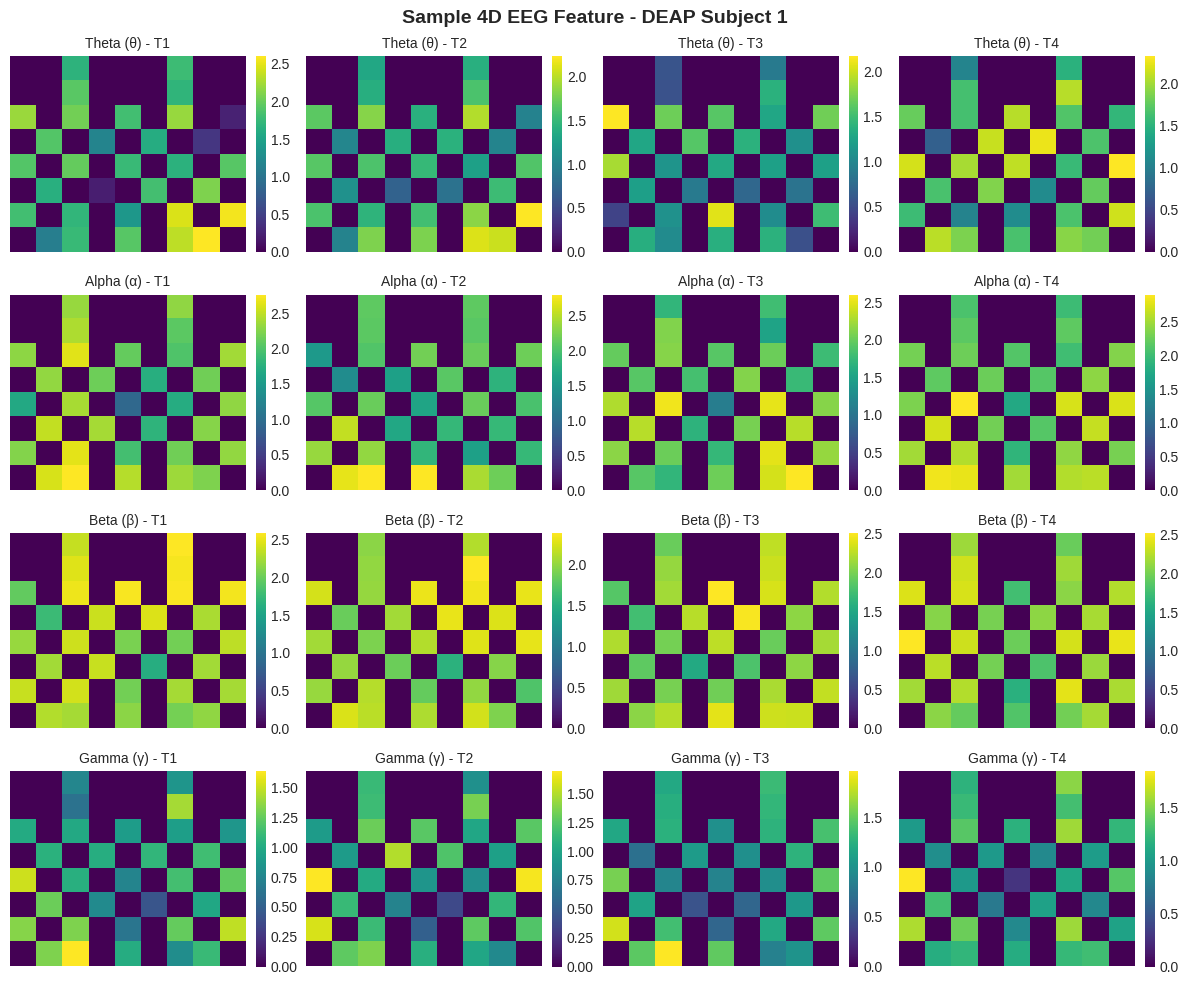

In [83]:
# Load DEAP data for subject 1 (example)
print("Loading DEAP dataset - Subject 1...")

features, valence_labels, arousal_labels = dataset_loader.load_deap_subject(subject_id=1)

if features is not None:
    print(f"\n   Data loaded successfully!")
    print(f"  Features shape: {features.shape}")
    print(f"  Valence labels: {valence_labels.shape}")
    print(f"  Arousal labels: {arousal_labels.shape}")
    print(f"  Class distribution (Valence): {np.bincount(valence_labels)}")
    print(f"  Class distribution (Arousal): {np.bincount(arousal_labels)}")
    
    # Visualize a sample feature
    print("\nVisualizing sample 4D feature...")
    visualizer.plot_feature_maps(features[0], title='Sample 4D EEG Feature - DEAP Subject 1')
else:
    print("✗ Failed to load data. Check dataset path.")

### Backup Results to Google Drive

In [84]:
# Setup rclone configuration (IMPORTANT: Add your config)
# Replace with your actual rclone configuration



rclone_config = '''
Put your rclone config content here
'''

backup_manager.setup_rclone_config(rclone_config)


print("    IMPORTANT: Configure rclone before backing up to Google Drive")
print("\nOption 1: Manual configuration")
print("  Run: !rclone config")
print("\nOption 2: Use existing config")
print("  Uncomment the code block above and paste your rclone config")
print("\nAfter configuration, run the backup:")

Rclone config written to /root/.config/rclone/rclone.conf
⚠ IMPORTANT: Configure rclone before backing up to Google Drive

Option 1: Manual configuration
  Run: !rclone config

Option 2: Use existing config
  Uncomment the code block above and paste your rclone config

After configuration, run the backup:


In [85]:
# Backup all results to Google Drive (run after training)
# UNCOMMENT AFTER CONFIGURING RCLONE

print("Starting backup to Google Drive...")
backup_manager.backup_all()

print("Backup code ready. Configure rclone and uncomment to run.")

Starting backup to Google Drive...

Starting backup to Google Drive...

Uploading ./checkpoints to gdrive:CA-CRNN-EEG/checkpoints...
Transferred:   	          0 B / 0 B, -, 0 B/s, ETA -
Checks:                14 / 14, 100%, Listed 28
Elapsed time:         0.2s
   Successfully uploaded to Google Drive
Uploading ./output to gdrive:CA-CRNN-EEG/outputs...
Transferred:   	          0 B / 0 B, -, 0 B/s, ETA -
Checks:                14 / 14, 100%, Listed 28
Elapsed time:         0.2s
   Successfully uploaded to Google Drive
Uploading ./output to gdrive:CA-CRNN-EEG/outputs...
Transferred:   	          0 B / 0 B, -, 0 B/s, ETA -
Checks:                28 / 28, 100%, Listed 56
Transferred:            0 / 1, 0%
Elapsed time:         0.5s
Transferring:
 *                         seed_iv_fold1_log.csv:  0% /0, 0/s, -Transferred:   	          0 B / 0 B, -, 0 B/s, ETA -
Checks:                28 / 28, 100%, Listed 56
Transferred:            0 / 1, 0%
Elapsed time:         0.5s
Transferring:
 *       

## Quick Test: SEED-IV Data Loader

Test the SEED-IV data loader with the fixed file structure.

In [86]:
# Test SEED-IV data loader
print("Testing SEED-IV Data Loader")
print("="*70)

# Try loading Subject 1, Session 1
print("\n    Loading Subject 1, Session 1...")
seed_features, seed_labels = dataset_loader.load_seed_session(1, 1)

if seed_features is not None and seed_labels is not None:
    print("\n    Successfully loaded SEED-IV data!")
    print(f"   Features shape: {seed_features.shape}")
    print(f"   Labels shape: {seed_labels.shape}")
    print(f"   Number of unique labels: {len(np.unique(seed_labels))}")
    print(f"   Label distribution:")
    for label in np.unique(seed_labels):
        count = np.sum(seed_labels == label)
        emotion = ['neutral', 'sad', 'fear', 'happy'][label]
        print(f"     {emotion} ({label}): {count} segments")
    
    print(f"\n   Expected 4D feature structure:")
    print(f"     Dimension 1 (samples): {seed_features.shape[0]}")
    print(f"     Dimension 2 (freq bands): {seed_features.shape[1]}")
    print(f"     Dimension 3 (height): {seed_features.shape[2]}")
    print(f"     Dimension 4 (width): {seed_features.shape[3]}")
    print(f"     Dimension 5 (time*2): {seed_features.shape[4]}")
else:
    print("\n    Failed to load SEED-IV data")
    print("   Check if the dataset path is correct in Config")

### Complete Training Pipeline (All Datasets)

Uncomment and run this section to train on all datasets and reproduce paper results.

STARTING COMPLETE TRAINING PIPELINE

⚠ This will train on DEAP, SEED-IV, and GAMEEMO datasets
  Expected duration: 6-12 hours depending on GPU
  Make sure datasets are properly mounted

EXPERIMENT 2: SEED-IV Dataset

Attempting to load SEED-IV data...
⚠ Note: SEED-IV loader may need adjustment based on actual file structure
Loading: /kaggle/input/seed-iv/eeg_raw_data/1/1_20160518.mat
Found 24 trial variables: ['cz_eeg1', 'cz_eeg10', 'cz_eeg11', 'cz_eeg12', 'cz_eeg13']...
Found 24 trial variables: ['cz_eeg1', 'cz_eeg10', 'cz_eeg11', 'cz_eeg12', 'cz_eeg13']...
Extracted 6702 segments with shape (4, 8, 9, 8)
Label distribution: [1754 1638 1591 1719]
   Loaded SEED-IV data: (6702, 4, 8, 9, 8)

Training Fold 1/5 - seed_iv

Extracted 6702 segments with shape (4, 8, 9, 8)
Label distribution: [1754 1638 1591 1719]
   Loaded SEED-IV data: (6702, 4, 8, 9, 8)

Training Fold 1/5 - seed_iv


Model Architecture:

Model Architecture:


Model: "CA_CRNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_4d_features (InputLayer)  │ (None, 4, 8, 9, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 8, 4, 8, 9)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 8, 512)         │     1,735,920 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 8, 256)         │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,573,684 (9.82 MB)

 Trainable params: 2,572,788 (9.81 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2676 - loss: 1.4234 - top_k_categorical_accuracy: 0.5295
Epoch 1: val_accuracy improved from -inf to 0.31022, saving model to ./checkpoints/seed_iv_fold1_best.h5

Epoch 1: val_accuracy improved from -inf to 0.31022, saving model to ./checkpoints/seed_iv_fold1_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.2677 - loss: 1.4231 - top_k_categorical_accuracy: 0.5296 - val_accuracy: 0.3102 - val_loss: 1.3744 - val_top_k_categorical_accuracy: 0.5690 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2867 - loss: 1.3860 - top_k_categorical_accuracy: 0.5361
Epoch 2: val_accuracy improved from 0.31022 to 0.38628, saving model to ./checkpoints/seed_iv_fold1_best.h5

Epoch 2: val_accuracy improved from 0.31022 to 0.38628, saving model to ./checkpoints/seed_iv_fold1_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.2871 - loss: 1.3857 - top_k_categorical_accuracy: 0.5366 - val_accuracy: 0.3863 - val_loss: 1.2988 - val_top_k_categorical_accuracy: 0.6331 - learning_rate: 0.0010
Epoch 3/100
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3542 - loss: 1.3157 - top_k_categorical_accuracy: 0.6236
Epoch 3: val_accuracy improved from 0.38628 to 0.45190, saving model to ./checkpoints/seed_iv_fold1_best.h5

Epoch 3: val_accuracy improved from 0.38628 to 0.45190, saving model to ./checkpoints/seed_iv_fold1_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.3545 - loss: 1.3153 - top_k_categorical_accuracy: 0.6239 - val_accuracy: 0.4519 - val_loss: 1.2030 - val_top_k_categorical_accuracy: 0.6957 - learning_rate: 0.0010
Epoch 4/100
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4069 - loss: 1.2257 - top_k_categorical_accuracy: 0.6825
Epoch 4: val_accuracy improved from 0.45190 to 0.49963, saving model to ./checkpoints/seed_iv_fold1_best.h5

Epoch 4: val_accuracy improved from 0.45190 to 0.49963, saving model to ./checkpoints/seed_iv_fold1_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.4074 - loss: 1.2248 - top_k_categorical_accuracy: 0.6829 - val_accuracy: 0.4996 - val_loss: 1.0877 - val_top_k_categorical_accuracy: 0.7621 - learning_rate: 0.0010
Epoch 5/100
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5067 - loss: 1.0530 - top_k_categorical_accuracy: 0.7754
Epoch 5: val_accuracy improved from 0.49963 to 0.55630, saving model to ./checkpoints/seed_iv_fold1_best.h5

Epoch 5: val_accuracy improved from 0.49963 to 0.55630, saving model to ./checkpoints/seed_iv_fold1_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.5074 - loss: 1.0516 - top_k_categorical_accuracy: 0.7760 - val_accuracy: 0.5563 - val_loss: 1.0002 - val_top_k_categorical_accuracy: 0.8069 - learning_rate: 0.0010
Epoch 6/100
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6154 - loss: 0.8481 - top_k_categorical_accuracy: 0.8712
Epoch 6: val_accuracy improved from 0.55630 to 0.76734, saving model to ./checkpoints/seed_iv_fold1_best.h5

Epoch 6: val_accuracy improved from 0.55630 to 0.76734, saving model to ./checkpoints/seed_iv_fold1_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.6162 - loss: 0.8465 - top_k_categorical_accuracy: 0.8718 - val_accuracy: 0.7673 - val_loss: 0.5403 - val_top_k_categorical_accuracy: 0.9627 - learning_rate: 0.0010
Epoch 7/100
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7534 - loss: 0.5624 - top_k_categorical_accuracy: 0.9598
Epoch 7: val_accuracy improved from 0.76734 to 0.84191, saving model to ./checkpoints/seed_iv_fold1_best.h5

Epoch 7: val_accuracy improved from 0.76734 to 0.84191, saving model to ./checkpoints/seed_iv_fold1_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.7538 - loss: 0.5620 - top_k_categorical_accuracy: 0.9599 - val_accuracy: 0.8419 - val_loss: 0.4010 - val_top_k_categorical_accuracy: 0.9881 - learning_rate: 0.0010
Epoch 8/100
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8546 - loss: 0.3740 - top_k_categorical_accuracy: 0.9876
Epoch 8: val_accuracy improved from 0.84191 to 0.87547, saving model to ./checkpoints/seed_iv_fold1_best.h5

Epoch 8: val_accuracy improved from 0.84191 to 0.87547, saving model to ./checkpoints/seed_iv_fold1_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8546 - loss: 0.3740 - top_k_categorical_accuracy: 0.9875 - val_accuracy: 0.8755 - val_loss: 0.2853 - val_top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010
Epoch 9/100
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8945 - loss: 0.2786 - top_k_categorical_accuracy: 0.9881
Epoch 9: val_accuracy improved from 0.87547 to 0.92767, saving model to ./checkpoints/seed_iv_fold1_best.h5

Epoch 9: val_accuracy improved from 0.87547 to 0.92767, saving model to ./checkpoints/seed_iv_fold1_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8948 - loss: 0.2777 - top_k_categorical_accuracy: 0.9882 - val_accuracy: 0.9277 - val_loss: 0.1726 - val_top_k_categorical_accuracy: 0.9963 - learning_rate: 0.0010
Epoch 10/100
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9433 - loss: 0.1553 - top_k_categorical_accuracy: 0.9965
Epoch 10: val_accuracy did not improve from 0.92767
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9432 - loss: 0.1557 - top_k_categorical_accuracy: 0.9965 - val_accuracy: 0.9172 - val_loss: 0.2514 - val_top_k_categorical_accuracy: 0.9940 - learning_rate: 0.0010

Epoch 10: val_accuracy did not improve from 0.92767
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9432 - loss: 0.1557 - top_k_categorical_accuracy: 0.9965 - val_accuracy: 0.9172 - val_loss: 0.2514 - val_top_k_categorical_accuracy: 0.9940 - learning_rate: 0.0010
Epoch 11/100
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9500 - loss: 0.1351 - t

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9501 - loss: 0.1349 - top_k_categorical_accuracy: 0.9969 - val_accuracy: 0.9687 - val_loss: 0.0818 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 0.0010
Epoch 12/100
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9636 - loss: 0.1095 - top_k_categorical_accuracy: 0.9953
Epoch 12: val_accuracy improved from 0.96868 to 0.98285, saving model to ./checkpoints/seed_iv_fold1_best.h5

Epoch 12: val_accuracy improved from 0.96868 to 0.98285, saving model to ./checkpoints/seed_iv_fold1_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9636 - loss: 0.1093 - top_k_categorical_accuracy: 0.9953 - val_accuracy: 0.9828 - val_loss: 0.0453 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 0.0010
Epoch 13/100
Epoch 13/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9780 - loss: 0.0674 - top_k_categorical_accuracy: 0.9989
Epoch 13: val_accuracy did not improve from 0.98285
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9779 - loss: 0.0675 - top_k_categorical_accuracy: 0.9989 - val_accuracy: 0.9709 - val_loss: 0.0813 - val_top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010

Epoch 13: val_accuracy did not improve from 0.98285
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9779 - loss: 0.0675 - top_k_categorical_accuracy: 0.9989 - val_accuracy: 0.9709 - val_loss: 0.0813 - val_top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010
Epoch 14/100
Epoch 14/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9733 - loss: 0.0798 - t

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9734 - loss: 0.0798 - top_k_categorical_accuracy: 0.9989 - val_accuracy: 0.9918 - val_loss: 0.0259 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 15/100
Epoch 15/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9849 - loss: 0.0449 - top_k_categorical_accuracy: 0.9990
Epoch 15: val_accuracy did not improve from 0.99180
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9849 - loss: 0.0449 - top_k_categorical_accuracy: 0.9990 - val_accuracy: 0.9881 - val_loss: 0.0468 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 0.0010

Epoch 15: val_accuracy did not improve from 0.99180
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9849 - loss: 0.0449 - top_k_categorical_accuracy: 0.9990 - val_accuracy: 0.9881 - val_loss: 0.0468 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 0.0010
Epoch 16/100
Epoch 16/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9894 - loss: 0.0344 - t


Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9781 - loss: 0.0693 - top_k_categorical_accuracy: 0.9962 - val_accuracy: 0.9925 - val_loss: 0.0275 - val_top_k_categorical_accuracy: 0.9985 - learning_rate: 0.0010
Epoch 22/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9781 - loss: 0.0693 - top_k_categorical_accuracy: 0.9962 - val_accuracy: 0.9925 - val_loss: 0.0275 - val_top_k_categorical_accuracy: 0.9985 - learning_rate: 0.0010
Epoch 22/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9930 - loss: 0.0201 - top_k_categorical_accuracy: 0.9999
Epoch 22: val_accuracy improved from 0.99254 to 0.99776, saving model to ./checkpoints/seed_iv_fold1_best.h5

Epoch 22: val_accuracy improved from 0.99254 to 0.99776, saving model to ./checkpoints/seed_iv_fold1_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9930 - loss: 0.0201 - top_k_categorical_accuracy: 0.9999 - val_accuracy: 0.9978 - val_loss: 0.0070 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 23/100
Epoch 23/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9987 - loss: 0.0074 - top_k_categorical_accuracy: 0.9998
Epoch 23: val_accuracy did not improve from 0.99776

Epoch 23: val_accuracy did not improve from 0.99776
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9987 - loss: 0.0074 - top_k_categorical_accuracy: 0.9997 - val_accuracy: 0.9978 - val_loss: 0.0064 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 5.0000e-04
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9987 - loss: 0.0074 - top_k_categorical_accuracy: 0.9997 - val_accuracy: 0.9978 - val_loss: 0.0064 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 5.0000e-04
Epoch 24/100
Epoch 24/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9978 - loss:

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9992 - loss: 0.0047 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9985 - val_loss: 0.0070 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 5.0000e-04
Epoch 26/100
Epoch 26/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9994 - loss: 0.0032 - top_k_categorical_accuracy: 0.9996
Epoch 26: val_accuracy did not improve from 0.99851

Epoch 26: val_accuracy did not improve from 0.99851
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9994 - loss: 0.0032 - top_k_categorical_accuracy: 0.9996 - val_accuracy: 0.9978 - val_loss: 0.0049 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 5.0000e-04
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9994 - loss: 0.0032 - top_k_categorical_accuracy: 0.9996 - val_accuracy: 0.9978 - val_loss: 0.0049 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 5.0000e-04
Epoch 27/100
Epoch 27/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss:

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9996 - loss: 0.0029 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9993 - val_loss: 0.0045 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 5.0000e-04
Epoch 29/100
Epoch 29/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9999 - loss: 0.0013 - top_k_categorical_accuracy: 1.0000
Epoch 29: val_accuracy did not improve from 0.99925
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9999 - loss: 0.0013 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9970 - val_loss: 0.0092 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04

Epoch 29: val_accuracy did not improve from 0.99925
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9999 - loss: 0.0013 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9970 - val_loss: 0.0092 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 30/100
Epoch 30/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9994 - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.2571 - loss: 1.4253 - top_k_categorical_accuracy: 0.5121 - val_accuracy: 0.3139 - val_loss: 1.3487 - val_top_k_categorical_accuracy: 0.5802 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3058 - loss: 1.3562 - top_k_categorical_accuracy: 0.5734
Epoch 2: val_accuracy improved from 0.31394 to 0.37584, saving model to ./checkpoints/seed_iv_fold2_best.h5

Epoch 2: val_accuracy improved from 0.31394 to 0.37584, saving model to ./checkpoints/seed_iv_fold2_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.3065 - loss: 1.3557 - top_k_categorical_accuracy: 0.5741 - val_accuracy: 0.3758 - val_loss: 1.2813 - val_top_k_categorical_accuracy: 0.6361 - learning_rate: 0.0010
Epoch 3/100
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3769 - loss: 1.2836 - top_k_categorical_accuracy: 0.6385
Epoch 3: val_accuracy improved from 0.37584 to 0.46309, saving model to ./checkpoints/seed_iv_fold2_best.h5

Epoch 3: val_accuracy improved from 0.37584 to 0.46309, saving model to ./checkpoints/seed_iv_fold2_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.3775 - loss: 1.2828 - top_k_categorical_accuracy: 0.6392 - val_accuracy: 0.4631 - val_loss: 1.1386 - val_top_k_categorical_accuracy: 0.7047 - learning_rate: 0.0010
Epoch 4/100
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4883 - loss: 1.1052 - top_k_categorical_accuracy: 0.7540
Epoch 4: val_accuracy improved from 0.46309 to 0.54362, saving model to ./checkpoints/seed_iv_fold2_best.h5

Epoch 4: val_accuracy improved from 0.46309 to 0.54362, saving model to ./checkpoints/seed_iv_fold2_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.4887 - loss: 1.1043 - top_k_categorical_accuracy: 0.7544 - val_accuracy: 0.5436 - val_loss: 1.0031 - val_top_k_categorical_accuracy: 0.7905 - learning_rate: 0.0010
Epoch 5/100
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6276 - loss: 0.8473 - top_k_categorical_accuracy: 0.8678
Epoch 5: val_accuracy improved from 0.54362 to 0.73751, saving model to ./checkpoints/seed_iv_fold2_best.h5

Epoch 5: val_accuracy improved from 0.54362 to 0.73751, saving model to ./checkpoints/seed_iv_fold2_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.6278 - loss: 0.8464 - top_k_categorical_accuracy: 0.8680 - val_accuracy: 0.7375 - val_loss: 0.5825 - val_top_k_categorical_accuracy: 0.9523 - learning_rate: 0.0010
Epoch 6/100
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7169 - loss: 0.5955 - top_k_categorical_accuracy: 0.9491
Epoch 6: val_accuracy improved from 0.73751 to 0.77405, saving model to ./checkpoints/seed_iv_fold2_best.h5

Epoch 6: val_accuracy improved from 0.73751 to 0.77405, saving model to ./checkpoints/seed_iv_fold2_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.7173 - loss: 0.5945 - top_k_categorical_accuracy: 0.9492 - val_accuracy: 0.7740 - val_loss: 0.4889 - val_top_k_categorical_accuracy: 0.9635 - learning_rate: 0.0010
Epoch 7/100
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8010 - loss: 0.4577 - top_k_categorical_accuracy: 0.9738
Epoch 7: val_accuracy improved from 0.77405 to 0.86726, saving model to ./checkpoints/seed_iv_fold2_best.h5

Epoch 7: val_accuracy improved from 0.77405 to 0.86726, saving model to ./checkpoints/seed_iv_fold2_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.8013 - loss: 0.4571 - top_k_categorical_accuracy: 0.9738 - val_accuracy: 0.8673 - val_loss: 0.3660 - val_top_k_categorical_accuracy: 0.9769 - learning_rate: 0.0010
Epoch 8/100
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8645 - loss: 0.3533 - top_k_categorical_accuracy: 0.9849
Epoch 8: val_accuracy improved from 0.86726 to 0.95004, saving model to ./checkpoints/seed_iv_fold2_best.h5

Epoch 8: val_accuracy improved from 0.86726 to 0.95004, saving model to ./checkpoints/seed_iv_fold2_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.8650 - loss: 0.3522 - top_k_categorical_accuracy: 0.9849 - val_accuracy: 0.9500 - val_loss: 0.1507 - val_top_k_categorical_accuracy: 0.9933 - learning_rate: 0.0010
Epoch 9/100
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9476 - loss: 0.1569 - top_k_categorical_accuracy: 0.9933
Epoch 9: val_accuracy did not improve from 0.95004
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9476 - loss: 0.1572 - top_k_categorical_accuracy: 0.9932 - val_accuracy: 0.9359 - val_loss: 0.1679 - val_top_k_categorical_accuracy: 0.9933 - learning_rate: 0.0010

Epoch 9: val_accuracy did not improve from 0.95004
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9476 - loss: 0.1572 - top_k_categorical_accuracy: 0.9932 - val_accuracy: 0.9359 - val_loss: 0.1679 - val_top_k_categorical_accuracy: 0.9933 - learning_rate: 0.0010
Epoch 10/100
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9464 - loss: 0.1658 - top_k

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9674 - loss: 0.0993 - top_k_categorical_accuracy: 0.9964 - val_accuracy: 0.9575 - val_loss: 0.1097 - val_top_k_categorical_accuracy: 0.9955 - learning_rate: 0.0010
Epoch 12/100
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9648 - loss: 0.0997 - top_k_categorical_accuracy: 0.9950
Epoch 12: val_accuracy improved from 0.95749 to 0.97987, saving model to ./checkpoints/seed_iv_fold2_best.h5

Epoch 12: val_accuracy improved from 0.95749 to 0.97987, saving model to ./checkpoints/seed_iv_fold2_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9647 - loss: 0.0998 - top_k_categorical_accuracy: 0.9950 - val_accuracy: 0.9799 - val_loss: 0.0729 - val_top_k_categorical_accuracy: 0.9985 - learning_rate: 0.0010
Epoch 13/100
Epoch 13/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9773 - loss: 0.0736 - top_k_categorical_accuracy: 0.9981
Epoch 13: val_accuracy improved from 0.97987 to 0.98956, saving model to ./checkpoints/seed_iv_fold2_best.h5

Epoch 13: val_accuracy improved from 0.97987 to 0.98956, saving model to ./checkpoints/seed_iv_fold2_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9773 - loss: 0.0736 - top_k_categorical_accuracy: 0.9981 - val_accuracy: 0.9896 - val_loss: 0.0331 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 0.0010
Epoch 14/100
Epoch 14/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9782 - loss: 0.0778 - top_k_categorical_accuracy: 0.9976
Epoch 14: val_accuracy did not improve from 0.98956
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9782 - loss: 0.0775 - top_k_categorical_accuracy: 0.9976 - val_accuracy: 0.9866 - val_loss: 0.0552 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 0.0010

Epoch 14: val_accuracy did not improve from 0.98956
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9782 - loss: 0.0775 - top_k_categorical_accuracy: 0.9976 - val_accuracy: 0.9866 - val_loss: 0.0552 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 0.0010
Epoch 15/100
Epoch 15/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9877 - loss: 0.0429 - t

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9951 - loss: 0.0195 - top_k_categorical_accuracy: 0.9997 - val_accuracy: 0.9911 - val_loss: 0.0274 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 18/100
Epoch 18/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9889 - loss: 0.0351 - top_k_categorical_accuracy: 0.9995
Epoch 18: val_accuracy did not improve from 0.99105
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9889 - loss: 0.0352 - top_k_categorical_accuracy: 0.9995 - val_accuracy: 0.9896 - val_loss: 0.0317 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 0.0010

Epoch 18: val_accuracy did not improve from 0.99105
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9889 - loss: 0.0352 - top_k_categorical_accuracy: 0.9995 - val_accuracy: 0.9896 - val_loss: 0.0317 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 0.0010
Epoch 19/100
Epoch 19/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9885 - loss: 0.0372 - t

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9907 - loss: 0.0310 - top_k_categorical_accuracy: 0.9992 - val_accuracy: 0.9925 - val_loss: 0.0238 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 21/100
Epoch 21/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9921 - loss: 0.0328 - top_k_categorical_accuracy: 0.9983
Epoch 21: val_accuracy did not improve from 0.99254
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9920 - loss: 0.0330 - top_k_categorical_accuracy: 0.9983 - val_accuracy: 0.9791 - val_loss: 0.0546 - val_top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010

Epoch 21: val_accuracy did not improve from 0.99254
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9920 - loss: 0.0330 - top_k_categorical_accuracy: 0.9983 - val_accuracy: 0.9791 - val_loss: 0.0546 - val_top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010
Epoch 22/100
Epoch 22/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9873 - loss: 0.0399 - to

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9901 - loss: 0.0426 - top_k_categorical_accuracy: 0.9995 - val_accuracy: 0.9970 - val_loss: 0.0096 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 27/100
Epoch 27/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9970 - loss: 0.0077 - top_k_categorical_accuracy: 0.9996
Epoch 27: val_accuracy did not improve from 0.99702

Epoch 27: val_accuracy did not improve from 0.99702
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9971 - loss: 0.0077 - top_k_categorical_accuracy: 0.9996 - val_accuracy: 0.9970 - val_loss: 0.0053 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9971 - loss: 0.0077 - top_k_categorical_accuracy: 0.9996 - val_accuracy: 0.9970 - val_loss: 0.0053 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 28/100
Epoch 28/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss:

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 1.0000 - loss: 0.0023 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9985 - val_loss: 0.0044 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 29/100
Epoch 29/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9998 - loss: 0.0021 - top_k_categorical_accuracy: 1.0000
Epoch 29: val_accuracy improved from 0.99851 to 1.00000, saving model to ./checkpoints/seed_iv_fold2_best.h5

Epoch 29: val_accuracy improved from 0.99851 to 1.00000, saving model to ./checkpoints/seed_iv_fold2_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9998 - loss: 0.0021 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 9.8511e-04 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 30/100
Epoch 30/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9998 - loss: 0.0018 - top_k_categorical_accuracy: 1.0000
Epoch 30: val_accuracy did not improve from 1.00000
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9998 - loss: 0.0018 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9985 - val_loss: 0.0043 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04

Epoch 30: val_accuracy did not improve from 1.00000
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9998 - loss: 0.0018 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9985 - val_loss: 0.0043 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 31/100
Epoch 31/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9998 - 

42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 167ms/step - accuracy: 0.2566 - loss: 1.4214 - top_k_categorical_accuracy: 0.5221 - val_accuracy: 0.3336 - val_loss: 1.3626 - val_top_k_categorical_accuracy: 0.5910 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3227 - loss: 1.3607 - top_k_categorical_accuracy: 0.5812
Epoch 2: val_accuracy improved from 0.33358 to 0.36343, saving model to ./checkpoints/seed_iv_fold3_best.h5

Epoch 2: val_accuracy improved from 0.33358 to 0.36343, saving model to ./checkpoints/seed_iv_fold3_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.3232 - loss: 1.3602 - top_k_categorical_accuracy: 0.5817 - val_accuracy: 0.3634 - val_loss: 1.3092 - val_top_k_categorical_accuracy: 0.6343 - learning_rate: 0.0010
Epoch 3/100
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3583 - loss: 1.3131 - top_k_categorical_accuracy: 0.6275
Epoch 3: val_accuracy improved from 0.36343 to 0.42537, saving model to ./checkpoints/seed_iv_fold3_best.h5

Epoch 3: val_accuracy improved from 0.36343 to 0.42537, saving model to ./checkpoints/seed_iv_fold3_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.3587 - loss: 1.3125 - top_k_categorical_accuracy: 0.6279 - val_accuracy: 0.4254 - val_loss: 1.2261 - val_top_k_categorical_accuracy: 0.7022 - learning_rate: 0.0010
Epoch 4/100
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4282 - loss: 1.1873 - top_k_categorical_accuracy: 0.6997
Epoch 4: val_accuracy improved from 0.42537 to 0.53806, saving model to ./checkpoints/seed_iv_fold3_best.h5

Epoch 4: val_accuracy improved from 0.42537 to 0.53806, saving model to ./checkpoints/seed_iv_fold3_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.4290 - loss: 1.1861 - top_k_categorical_accuracy: 0.7002 - val_accuracy: 0.5381 - val_loss: 0.9546 - val_top_k_categorical_accuracy: 0.8157 - learning_rate: 0.0010
Epoch 5/100
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5742 - loss: 0.9180 - top_k_categorical_accuracy: 0.8209
Epoch 5: val_accuracy improved from 0.53806 to 0.68955, saving model to ./checkpoints/seed_iv_fold3_best.h5

Epoch 5: val_accuracy improved from 0.53806 to 0.68955, saving model to ./checkpoints/seed_iv_fold3_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.5746 - loss: 0.9174 - top_k_categorical_accuracy: 0.8212 - val_accuracy: 0.6896 - val_loss: 0.7211 - val_top_k_categorical_accuracy: 0.9299 - learning_rate: 0.0010
Epoch 6/100
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7256 - loss: 0.6403 - top_k_categorical_accuracy: 0.9389
Epoch 6: val_accuracy improved from 0.68955 to 0.78582, saving model to ./checkpoints/seed_iv_fold3_best.h5

Epoch 6: val_accuracy improved from 0.68955 to 0.78582, saving model to ./checkpoints/seed_iv_fold3_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.7260 - loss: 0.6391 - top_k_categorical_accuracy: 0.9392 - val_accuracy: 0.7858 - val_loss: 0.5514 - val_top_k_categorical_accuracy: 0.9657 - learning_rate: 0.0010
Epoch 7/100
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8035 - loss: 0.4636 - top_k_categorical_accuracy: 0.9760
Epoch 7: val_accuracy improved from 0.78582 to 0.85970, saving model to ./checkpoints/seed_iv_fold3_best.h5

Epoch 7: val_accuracy improved from 0.78582 to 0.85970, saving model to ./checkpoints/seed_iv_fold3_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.8037 - loss: 0.4635 - top_k_categorical_accuracy: 0.9760 - val_accuracy: 0.8597 - val_loss: 0.3544 - val_top_k_categorical_accuracy: 0.9858 - learning_rate: 0.0010
Epoch 8/100
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8819 - loss: 0.3120 - top_k_categorical_accuracy: 0.9914
Epoch 8: val_accuracy improved from 0.85970 to 0.94104, saving model to ./checkpoints/seed_iv_fold3_best.h5

Epoch 8: val_accuracy improved from 0.85970 to 0.94104, saving model to ./checkpoints/seed_iv_fold3_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8824 - loss: 0.3108 - top_k_categorical_accuracy: 0.9915 - val_accuracy: 0.9410 - val_loss: 0.1692 - val_top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010
Epoch 9/100
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9463 - loss: 0.1689 - top_k_categorical_accuracy: 0.9950
Epoch 9: val_accuracy improved from 0.94104 to 0.95896, saving model to ./checkpoints/seed_iv_fold3_best.h5

Epoch 9: val_accuracy improved from 0.94104 to 0.95896, saving model to ./checkpoints/seed_iv_fold3_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9461 - loss: 0.1693 - top_k_categorical_accuracy: 0.9950 - val_accuracy: 0.9590 - val_loss: 0.1212 - val_top_k_categorical_accuracy: 0.9933 - learning_rate: 0.0010
Epoch 10/100
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9649 - loss: 0.1095 - top_k_categorical_accuracy: 0.9947
Epoch 10: val_accuracy improved from 0.95896 to 0.97313, saving model to ./checkpoints/seed_iv_fold3_best.h5

Epoch 10: val_accuracy improved from 0.95896 to 0.97313, saving model to ./checkpoints/seed_iv_fold3_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9649 - loss: 0.1094 - top_k_categorical_accuracy: 0.9947 - val_accuracy: 0.9731 - val_loss: 0.0751 - val_top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010
Epoch 11/100
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9678 - loss: 0.1068 - top_k_categorical_accuracy: 0.9956
Epoch 11: val_accuracy improved from 0.97313 to 0.98806, saving model to ./checkpoints/seed_iv_fold3_best.h5

Epoch 11: val_accuracy improved from 0.97313 to 0.98806, saving model to ./checkpoints/seed_iv_fold3_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9679 - loss: 0.1064 - top_k_categorical_accuracy: 0.9956 - val_accuracy: 0.9881 - val_loss: 0.0415 - val_top_k_categorical_accuracy: 0.9985 - learning_rate: 0.0010
Epoch 12/100
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9823 - loss: 0.0649 - top_k_categorical_accuracy: 0.9975
Epoch 12: val_accuracy did not improve from 0.98806
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9824 - loss: 0.0648 - top_k_categorical_accuracy: 0.9975 - val_accuracy: 0.9761 - val_loss: 0.0960 - val_top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010

Epoch 12: val_accuracy did not improve from 0.98806
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9824 - loss: 0.0648 - top_k_categorical_accuracy: 0.9975 - val_accuracy: 0.9761 - val_loss: 0.0960 - val_top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010
Epoch 13/100
Epoch 13/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9689 - loss: 0.1027 - t

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9792 - loss: 0.0699 - top_k_categorical_accuracy: 0.9959 - val_accuracy: 0.9903 - val_loss: 0.0299 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 0.0010
Epoch 16/100
Epoch 16/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9904 - loss: 0.0299 - top_k_categorical_accuracy: 0.9991
Epoch 16: val_accuracy did not improve from 0.99030

Epoch 16: val_accuracy did not improve from 0.99030
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9904 - loss: 0.0299 - top_k_categorical_accuracy: 0.9991 - val_accuracy: 0.9903 - val_loss: 0.0193 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9904 - loss: 0.0299 - top_k_categorical_accuracy: 0.9991 - val_accuracy: 0.9903 - val_loss: 0.0193 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 17/100
Epoch 17/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9925 - loss: 0.0213 - to

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9825 - loss: 0.0553 - top_k_categorical_accuracy: 0.9987 - val_accuracy: 0.9948 - val_loss: 0.0189 - val_top_k_categorical_accuracy: 0.9985 - learning_rate: 0.0010
Epoch 19/100
Epoch 19/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9959 - loss: 0.0165 - top_k_categorical_accuracy: 0.9992
Epoch 19: val_accuracy improved from 0.99478 to 0.99701, saving model to ./checkpoints/seed_iv_fold3_best.h5

Epoch 19: val_accuracy improved from 0.99478 to 0.99701, saving model to ./checkpoints/seed_iv_fold3_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9959 - loss: 0.0165 - top_k_categorical_accuracy: 0.9992 - val_accuracy: 0.9970 - val_loss: 0.0137 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 20/100
Epoch 20/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9946 - loss: 0.0213 - top_k_categorical_accuracy: 0.9992
Epoch 20: val_accuracy did not improve from 0.99701
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9945 - loss: 0.0215 - top_k_categorical_accuracy: 0.9992 - val_accuracy: 0.9843 - val_loss: 0.0589 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010

Epoch 20: val_accuracy did not improve from 0.99701
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9945 - loss: 0.0215 - top_k_categorical_accuracy: 0.9992 - val_accuracy: 0.9843 - val_loss: 0.0589 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 21/100
Epoch 21/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9947 - loss: 0.0199 - to

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9976 - loss: 0.0109 - top_k_categorical_accuracy: 0.9997 - val_accuracy: 0.9985 - val_loss: 0.0046 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 28/100
Epoch 28/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9988 - loss: 0.0046 - top_k_categorical_accuracy: 1.0000
Epoch 28: val_accuracy improved from 0.99851 to 0.99925, saving model to ./checkpoints/seed_iv_fold3_best.h5

Epoch 28: val_accuracy improved from 0.99851 to 0.99925, saving model to ./checkpoints/seed_iv_fold3_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9988 - loss: 0.0046 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9993 - val_loss: 0.0023 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 29/100
Epoch 29/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9987 - loss: 0.0052 - top_k_categorical_accuracy: 0.9999
Epoch 29: val_accuracy did not improve from 0.99925
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9987 - loss: 0.0052 - top_k_categorical_accuracy: 0.9999 - val_accuracy: 0.9970 - val_loss: 0.0109 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04

Epoch 29: val_accuracy did not improve from 0.99925
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9987 - loss: 0.0052 - top_k_categorical_accuracy: 0.9999 - val_accuracy: 0.9970 - val_loss: 0.0109 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 30/100
Epoch 30/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9989 - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9991 - loss: 0.0019 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 4.7835e-04 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 33/100
Epoch 33/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9997 - loss: 0.0012 - top_k_categorical_accuracy: 1.0000
Epoch 33: val_accuracy did not improve from 1.00000

Epoch 33: val_accuracy did not improve from 1.00000
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9997 - loss: 0.0012 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 2.9868e-04 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9997 - loss: 0.0012 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 2.9868e-04 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 34/100
Epoch 34/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0

42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 166ms/step - accuracy: 0.2585 - loss: 1.4227 - top_k_categorical_accuracy: 0.5061 - val_accuracy: 0.3082 - val_loss: 1.3709 - val_top_k_categorical_accuracy: 0.5746 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2920 - loss: 1.3763 - top_k_categorical_accuracy: 0.5474
Epoch 2: val_accuracy improved from 0.30821 to 0.35373, saving model to ./checkpoints/seed_iv_fold4_best.h5

Epoch 2: val_accuracy improved from 0.30821 to 0.35373, saving model to ./checkpoints/seed_iv_fold4_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.2923 - loss: 1.3760 - top_k_categorical_accuracy: 0.5480 - val_accuracy: 0.3537 - val_loss: 1.3195 - val_top_k_categorical_accuracy: 0.6351 - learning_rate: 0.0010
Epoch 3/100
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3437 - loss: 1.3259 - top_k_categorical_accuracy: 0.6149
Epoch 3: val_accuracy improved from 0.35373 to 0.42687, saving model to ./checkpoints/seed_iv_fold4_best.h5

Epoch 3: val_accuracy improved from 0.35373 to 0.42687, saving model to ./checkpoints/seed_iv_fold4_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.3442 - loss: 1.3253 - top_k_categorical_accuracy: 0.6154 - val_accuracy: 0.4269 - val_loss: 1.2074 - val_top_k_categorical_accuracy: 0.6993 - learning_rate: 0.0010
Epoch 4/100
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4292 - loss: 1.2072 - top_k_categorical_accuracy: 0.6975
Epoch 4: val_accuracy improved from 0.42687 to 0.55149, saving model to ./checkpoints/seed_iv_fold4_best.h5

Epoch 4: val_accuracy improved from 0.42687 to 0.55149, saving model to ./checkpoints/seed_iv_fold4_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.4300 - loss: 1.2060 - top_k_categorical_accuracy: 0.6983 - val_accuracy: 0.5515 - val_loss: 1.0023 - val_top_k_categorical_accuracy: 0.8090 - learning_rate: 0.0010
Epoch 5/100
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5535 - loss: 0.9767 - top_k_categorical_accuracy: 0.8294
Epoch 5: val_accuracy improved from 0.55149 to 0.76567, saving model to ./checkpoints/seed_iv_fold4_best.h5

Epoch 5: val_accuracy improved from 0.55149 to 0.76567, saving model to ./checkpoints/seed_iv_fold4_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.5550 - loss: 0.9743 - top_k_categorical_accuracy: 0.8304 - val_accuracy: 0.7657 - val_loss: 0.5742 - val_top_k_categorical_accuracy: 0.9582 - learning_rate: 0.0010
Epoch 6/100
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7646 - loss: 0.5758 - top_k_categorical_accuracy: 0.9574
Epoch 6: val_accuracy improved from 0.76567 to 0.85597, saving model to ./checkpoints/seed_iv_fold4_best.h5

Epoch 6: val_accuracy improved from 0.76567 to 0.85597, saving model to ./checkpoints/seed_iv_fold4_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.7649 - loss: 0.5754 - top_k_categorical_accuracy: 0.9573 - val_accuracy: 0.8560 - val_loss: 0.3786 - val_top_k_categorical_accuracy: 0.9724 - learning_rate: 0.0010
Epoch 7/100
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8973 - loss: 0.2911 - top_k_categorical_accuracy: 0.9838
Epoch 7: val_accuracy improved from 0.85597 to 0.95896, saving model to ./checkpoints/seed_iv_fold4_best.h5

Epoch 7: val_accuracy improved from 0.85597 to 0.95896, saving model to ./checkpoints/seed_iv_fold4_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8977 - loss: 0.2902 - top_k_categorical_accuracy: 0.9838 - val_accuracy: 0.9590 - val_loss: 0.1185 - val_top_k_categorical_accuracy: 0.9948 - learning_rate: 0.0010
Epoch 8/100
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9540 - loss: 0.1351 - top_k_categorical_accuracy: 0.9934
Epoch 8: val_accuracy improved from 0.95896 to 0.97612, saving model to ./checkpoints/seed_iv_fold4_best.h5

Epoch 8: val_accuracy improved from 0.95896 to 0.97612, saving model to ./checkpoints/seed_iv_fold4_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9541 - loss: 0.1348 - top_k_categorical_accuracy: 0.9934 - val_accuracy: 0.9761 - val_loss: 0.0689 - val_top_k_categorical_accuracy: 0.9985 - learning_rate: 0.0010
Epoch 9/100
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9652 - loss: 0.1031 - top_k_categorical_accuracy: 0.9967
Epoch 9: val_accuracy improved from 0.97612 to 0.98134, saving model to ./checkpoints/seed_iv_fold4_best.h5

Epoch 9: val_accuracy improved from 0.97612 to 0.98134, saving model to ./checkpoints/seed_iv_fold4_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9652 - loss: 0.1032 - top_k_categorical_accuracy: 0.9966 - val_accuracy: 0.9813 - val_loss: 0.0635 - val_top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010
Epoch 10/100
 1/42 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9922 - loss: 0.0512 - top_k_categorical_accuracy: 1.0000Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9740 - loss: 0.0831 - top_k_categorical_accuracy: 0.9967
Epoch 10: val_accuracy did not improve from 0.98134
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9740 - loss: 0.0832 - top_k_categorical_accuracy: 0.9967 - val_accuracy: 0.9731 - val_loss: 0.0868 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 0.0010

Epoch 10: val_accuracy did not improve from 0.98134
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9740 - loss: 0.0832 - top_k_categorical_accuracy: 0.9967 - val_accuracy: 0.9731 - val_loss: 0.0868 - val_top_k_categorical_accuracy: 0.9978 - learning_rate:

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9747 - loss: 0.0772 - top_k_categorical_accuracy: 0.9956 - val_accuracy: 0.9948 - val_loss: 0.0200 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 13/100
Epoch 13/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9918 - loss: 0.0329 - top_k_categorical_accuracy: 0.9983
Epoch 13: val_accuracy did not improve from 0.99478
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9918 - loss: 0.0331 - top_k_categorical_accuracy: 0.9983 - val_accuracy: 0.9925 - val_loss: 0.0218 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010

Epoch 13: val_accuracy did not improve from 0.99478
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9918 - loss: 0.0331 - top_k_categorical_accuracy: 0.9983 - val_accuracy: 0.9925 - val_loss: 0.0218 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 14/100
Epoch 14/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9922 - loss: 0.0276 - t

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9824 - loss: 0.0656 - top_k_categorical_accuracy: 0.9978 - val_accuracy: 0.9955 - val_loss: 0.0129 - val_top_k_categorical_accuracy: 0.9993 - learning_rate: 0.0010
Epoch 18/100
Epoch 18/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9950 - loss: 0.0149 - top_k_categorical_accuracy: 0.9987
Epoch 18: val_accuracy improved from 0.99552 to 0.99627, saving model to ./checkpoints/seed_iv_fold4_best.h5

Epoch 18: val_accuracy improved from 0.99552 to 0.99627, saving model to ./checkpoints/seed_iv_fold4_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9950 - loss: 0.0149 - top_k_categorical_accuracy: 0.9988 - val_accuracy: 0.9963 - val_loss: 0.0079 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 19/100
Epoch 19/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9979 - loss: 0.0099 - top_k_categorical_accuracy: 0.9997
Epoch 19: val_accuracy did not improve from 0.99627
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9979 - loss: 0.0100 - top_k_categorical_accuracy: 0.9997 - val_accuracy: 0.9948 - val_loss: 0.0131 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010

Epoch 19: val_accuracy did not improve from 0.99627
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9979 - loss: 0.0100 - top_k_categorical_accuracy: 0.9997 - val_accuracy: 0.9948 - val_loss: 0.0131 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 20/100
Epoch 20/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9945 - loss: 0.0176 - t

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9974 - loss: 0.0121 - top_k_categorical_accuracy: 0.9996 - val_accuracy: 0.9970 - val_loss: 0.0082 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 25/100
Epoch 25/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9972 - loss: 0.0080 - top_k_categorical_accuracy: 0.9999
Epoch 25: val_accuracy did not improve from 0.99701
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9972 - loss: 0.0080 - top_k_categorical_accuracy: 0.9999 - val_accuracy: 0.9955 - val_loss: 0.0133 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04

Epoch 25: val_accuracy did not improve from 0.99701
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9972 - loss: 0.0080 - top_k_categorical_accuracy: 0.9999 - val_accuracy: 0.9955 - val_loss: 0.0133 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 26/100
Epoch 26/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9991 - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9989 - loss: 0.0028 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9993 - val_loss: 0.0068 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 28/100
 2/42 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 1.0000 - loss: 6.9888e-04 - top_k_categorical_accuracy: 1.0000 Epoch 28/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0010 - top_k_categorical_accuracy: 1.0000
Epoch 28: val_accuracy did not improve from 0.99925

Epoch 28: val_accuracy did not improve from 0.99925
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 1.0000 - loss: 0.0010 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9978 - val_loss: 0.0060 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 1.0000 - loss: 0.0010 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9978 - val_loss: 0.0060 - val_top_k_categorical_accuracy: 1.0000 - le

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9983 - loss: 0.0055 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.1999e-04 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.5000e-04
Epoch 41/100
Epoch 41/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 5.9147e-04 - top_k_categorical_accuracy: 1.0000
Epoch 41: val_accuracy did not improve from 1.00000

Epoch 41: val_accuracy did not improve from 1.00000
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 1.0000 - loss: 5.9325e-04 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 9.7667e-05 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.5000e-04
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 1.0000 - loss: 5.9325e-04 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 9.7667e-05 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 2.5000e-04
Epoch 42/100
Epoch 42/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step -

42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 178ms/step - accuracy: 0.2696 - loss: 1.4210 - top_k_categorical_accuracy: 0.5159 - val_accuracy: 0.3164 - val_loss: 1.3733 - val_top_k_categorical_accuracy: 0.5522 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2695 - loss: 1.3896 - top_k_categorical_accuracy: 0.5272
Epoch 2: val_accuracy improved from 0.31642 to 0.37910, saving model to ./checkpoints/seed_iv_fold5_best.h5

Epoch 2: val_accuracy improved from 0.31642 to 0.37910, saving model to ./checkpoints/seed_iv_fold5_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.2702 - loss: 1.3892 - top_k_categorical_accuracy: 0.5278 - val_accuracy: 0.3791 - val_loss: 1.3105 - val_top_k_categorical_accuracy: 0.6500 - learning_rate: 0.0010
Epoch 3/100
 1/42 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.3125 - loss: 1.4004 - top_k_categorical_accuracy: 0.5859Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3613 - loss: 1.3225 - top_k_categorical_accuracy: 0.6171
Epoch 3: val_accuracy improved from 0.37910 to 0.41642, saving model to ./checkpoints/seed_iv_fold5_best.h5

Epoch 3: val_accuracy improved from 0.37910 to 0.41642, saving model to ./checkpoints/seed_iv_fold5_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.3618 - loss: 1.3218 - top_k_categorical_accuracy: 0.6178 - val_accuracy: 0.4164 - val_loss: 1.2143 - val_top_k_categorical_accuracy: 0.6985 - learning_rate: 0.0010
Epoch 4/100
 1/42 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.4297 - loss: 1.2141 - top_k_categorical_accuracy: 0.7109Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4719 - loss: 1.1535 - top_k_categorical_accuracy: 0.7433
Epoch 4: val_accuracy improved from 0.41642 to 0.63209, saving model to ./checkpoints/seed_iv_fold5_best.h5

Epoch 4: val_accuracy improved from 0.41642 to 0.63209, saving model to ./checkpoints/seed_iv_fold5_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.4727 - loss: 1.1519 - top_k_categorical_accuracy: 0.7443 - val_accuracy: 0.6321 - val_loss: 0.8305 - val_top_k_categorical_accuracy: 0.9075 - learning_rate: 0.0010
Epoch 5/100
 1/42 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.5156 - loss: 0.9659 - top_k_categorical_accuracy: 0.8359Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6273 - loss: 0.8282 - top_k_categorical_accuracy: 0.8962
Epoch 5: val_accuracy improved from 0.63209 to 0.80299, saving model to ./checkpoints/seed_iv_fold5_best.h5

Epoch 5: val_accuracy improved from 0.63209 to 0.80299, saving model to ./checkpoints/seed_iv_fold5_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.6283 - loss: 0.8264 - top_k_categorical_accuracy: 0.8968 - val_accuracy: 0.8030 - val_loss: 0.4774 - val_top_k_categorical_accuracy: 0.9791 - learning_rate: 0.0010
Epoch 6/100
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7732 - loss: 0.5421 - top_k_categorical_accuracy: 0.9601
Epoch 6: val_accuracy improved from 0.80299 to 0.86194, saving model to ./checkpoints/seed_iv_fold5_best.h5

Epoch 6: val_accuracy improved from 0.80299 to 0.86194, saving model to ./checkpoints/seed_iv_fold5_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.7739 - loss: 0.5405 - top_k_categorical_accuracy: 0.9604 - val_accuracy: 0.8619 - val_loss: 0.3410 - val_top_k_categorical_accuracy: 0.9873 - learning_rate: 0.0010
Epoch 7/100
 1/42 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.8984 - loss: 0.2930 - top_k_categorical_accuracy: 0.9766Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8831 - loss: 0.3179 - top_k_categorical_accuracy: 0.9924
Epoch 7: val_accuracy improved from 0.86194 to 0.94030, saving model to ./checkpoints/seed_iv_fold5_best.h5

Epoch 7: val_accuracy improved from 0.86194 to 0.94030, saving model to ./checkpoints/seed_iv_fold5_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.8834 - loss: 0.3171 - top_k_categorical_accuracy: 0.9924 - val_accuracy: 0.9403 - val_loss: 0.1679 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 0.0010
Epoch 8/100
 1/42 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9297 - loss: 0.2032 - top_k_categorical_accuracy: 1.0000Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9384 - loss: 0.1786 - top_k_categorical_accuracy: 0.9973
Epoch 8: val_accuracy improved from 0.94030 to 0.94478, saving model to ./checkpoints/seed_iv_fold5_best.h5

Epoch 8: val_accuracy improved from 0.94030 to 0.94478, saving model to ./checkpoints/seed_iv_fold5_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9385 - loss: 0.1783 - top_k_categorical_accuracy: 0.9973 - val_accuracy: 0.9448 - val_loss: 0.1530 - val_top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010
Epoch 9/100
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9481 - loss: 0.1597 - top_k_categorical_accuracy: 0.9970
Epoch 9: val_accuracy did not improve from 0.94478
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9481 - loss: 0.1599 - top_k_categorical_accuracy: 0.9970 - val_accuracy: 0.9187 - val_loss: 0.2345 - val_top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010

Epoch 9: val_accuracy did not improve from 0.94478
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9481 - loss: 0.1599 - top_k_categorical_accuracy: 0.9970 - val_accuracy: 0.9187 - val_loss: 0.2345 - val_top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010
Epoch 10/100
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9528 - loss: 0.1502 - top

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9531 - loss: 0.1491 - top_k_categorical_accuracy: 0.9941 - val_accuracy: 0.9687 - val_loss: 0.0998 - val_top_k_categorical_accuracy: 0.9955 - learning_rate: 0.0010
Epoch 11/100
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9759 - loss: 0.0762 - top_k_categorical_accuracy: 0.9989
Epoch 11: val_accuracy improved from 0.96866 to 0.97015, saving model to ./checkpoints/seed_iv_fold5_best.h5

Epoch 11: val_accuracy improved from 0.96866 to 0.97015, saving model to ./checkpoints/seed_iv_fold5_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9759 - loss: 0.0763 - top_k_categorical_accuracy: 0.9989 - val_accuracy: 0.9701 - val_loss: 0.0807 - val_top_k_categorical_accuracy: 0.9985 - learning_rate: 0.0010
Epoch 12/100
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9715 - loss: 0.0920 - top_k_categorical_accuracy: 0.9968
Epoch 12: val_accuracy improved from 0.97015 to 0.98134, saving model to ./checkpoints/seed_iv_fold5_best.h5

Epoch 12: val_accuracy improved from 0.97015 to 0.98134, saving model to ./checkpoints/seed_iv_fold5_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9714 - loss: 0.0922 - top_k_categorical_accuracy: 0.9968 - val_accuracy: 0.9813 - val_loss: 0.0560 - val_top_k_categorical_accuracy: 0.9985 - learning_rate: 0.0010
Epoch 13/100
 1/42 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 0.0284 - top_k_categorical_accuracy: 1.0000Epoch 13/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9864 - loss: 0.0471 - top_k_categorical_accuracy: 0.9991
Epoch 13: val_accuracy improved from 0.98134 to 0.99030, saving model to ./checkpoints/seed_iv_fold5_best.h5

Epoch 13: val_accuracy improved from 0.98134 to 0.99030, saving model to ./checkpoints/seed_iv_fold5_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9863 - loss: 0.0472 - top_k_categorical_accuracy: 0.9991 - val_accuracy: 0.9903 - val_loss: 0.0268 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 14/100
Epoch 14/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9868 - loss: 0.0394 - top_k_categorical_accuracy: 0.9992
Epoch 14: val_accuracy did not improve from 0.99030

Epoch 14: val_accuracy did not improve from 0.99030
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9868 - loss: 0.0395 - top_k_categorical_accuracy: 0.9992 - val_accuracy: 0.9903 - val_loss: 0.0266 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9868 - loss: 0.0395 - top_k_categorical_accuracy: 0.9992 - val_accuracy: 0.9903 - val_loss: 0.0266 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 15/100
Epoch 15/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9894 - loss: 0.0316 - t

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9894 - loss: 0.0316 - top_k_categorical_accuracy: 0.9995 - val_accuracy: 0.9933 - val_loss: 0.0194 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 16/100
Epoch 16/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9938 - loss: 0.0229 - top_k_categorical_accuracy: 0.9988
Epoch 16: val_accuracy did not improve from 0.99328
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9938 - loss: 0.0229 - top_k_categorical_accuracy: 0.9988 - val_accuracy: 0.9933 - val_loss: 0.0257 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010

Epoch 16: val_accuracy did not improve from 0.99328
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9938 - loss: 0.0229 - top_k_categorical_accuracy: 0.9988 - val_accuracy: 0.9933 - val_loss: 0.0257 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 17/100
Epoch 17/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9814 - loss: 0.0623 - t

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9921 - loss: 0.0269 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9948 - val_loss: 0.0188 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 22/100
 1/42 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 0.0053 - top_k_categorical_accuracy: 1.0000Epoch 22/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9979 - loss: 0.0089 - top_k_categorical_accuracy: 0.9999
Epoch 22: val_accuracy improved from 0.99478 to 0.99701, saving model to ./checkpoints/seed_iv_fold5_best.h5

Epoch 22: val_accuracy improved from 0.99478 to 0.99701, saving model to ./checkpoints/seed_iv_fold5_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9979 - loss: 0.0089 - top_k_categorical_accuracy: 0.9999 - val_accuracy: 0.9970 - val_loss: 0.0093 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 23/100
 1/42 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 1.0000 - loss: 8.5628e-04 - top_k_categorical_accuracy: 1.0000Epoch 23/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9990 - loss: 0.0045 - top_k_categorical_accuracy: 1.0000
Epoch 23: val_accuracy did not improve from 0.99701
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9990 - loss: 0.0045 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9970 - val_loss: 0.0104 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04

Epoch 23: val_accuracy did not improve from 0.99701
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9990 - loss: 0.0045 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9970 - val_loss: 0.0104 - val_top_k_categorical_accuracy: 1.0000 - le

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9988 - loss: 0.0029 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9978 - val_loss: 0.0074 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 26/100
Epoch 26/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9999 - loss: 0.0020 - top_k_categorical_accuracy: 1.0000
Epoch 26: val_accuracy did not improve from 0.99776
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9999 - loss: 0.0020 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9970 - val_loss: 0.0110 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04

Epoch 26: val_accuracy did not improve from 0.99776
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9999 - loss: 0.0020 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9970 - val_loss: 0.0110 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 27/100
Epoch 27/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9995 - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9998 - loss: 0.0013 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9993 - val_loss: 0.0019 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 30/100
 2/42 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 1.0000 - loss: 2.8518e-04 - top_k_categorical_accuracy: 1.0000 Epoch 30/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 6.2428e-04 - top_k_categorical_accuracy: 1.0000
Epoch 30: val_accuracy did not improve from 0.99925
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 1.0000 - loss: 6.2522e-04 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9993 - val_loss: 0.0025 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-04
Epoch 31/100

Epoch 30: val_accuracy did not improve from 0.99925
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 1.0000 - loss: 6.2522e-04 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9993 - val_loss: 0.0025 - val_top_k_categori

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9999 - loss: 7.3685e-04 - top_k_categorical_accuracy: 0.9999 - val_accuracy: 1.0000 - val_loss: 2.9444e-04 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.2500e-04
Epoch 43/100
 2/42 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 1.0000 - loss: 6.5053e-04 - top_k_categorical_accuracy: 1.0000 Epoch 43/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9998 - loss: 6.9382e-04 - top_k_categorical_accuracy: 1.0000
Epoch 43: val_accuracy did not improve from 1.00000
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9998 - loss: 6.9212e-04 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9993 - val_loss: 0.0030 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.2500e-04

Epoch 43: val_accuracy did not improve from 1.00000
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9998 - loss: 6.9212e-04 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9993 - val_loss: 0.0030 - val_top_k_categorical_a

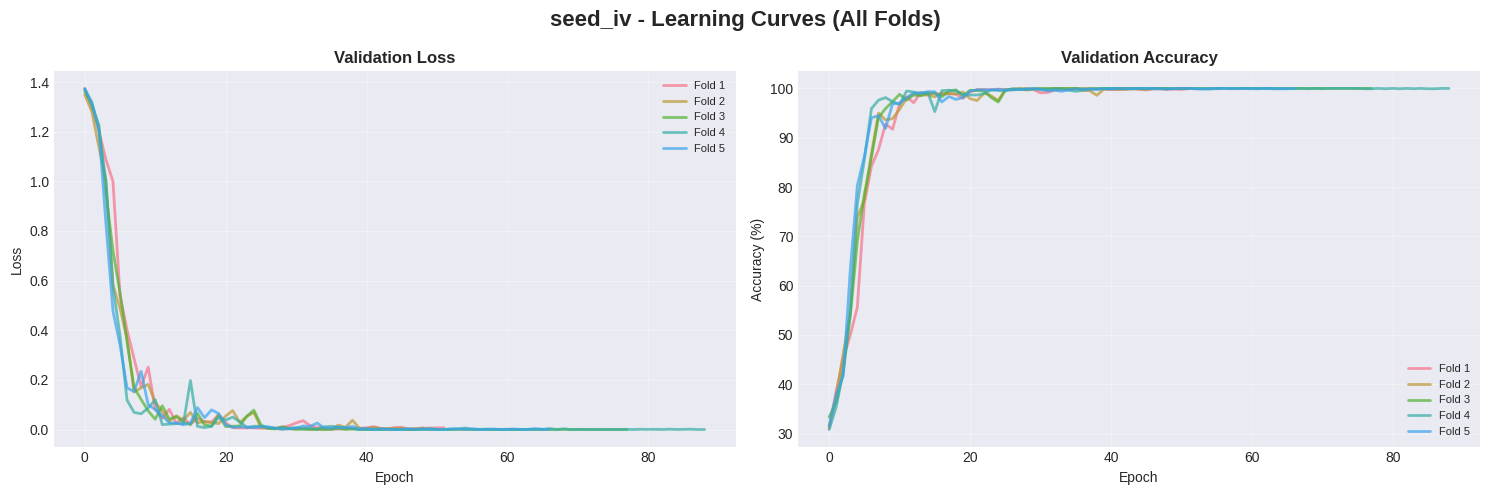

Saved plot to ./visualizations/seed_iv_folds_comparison.png


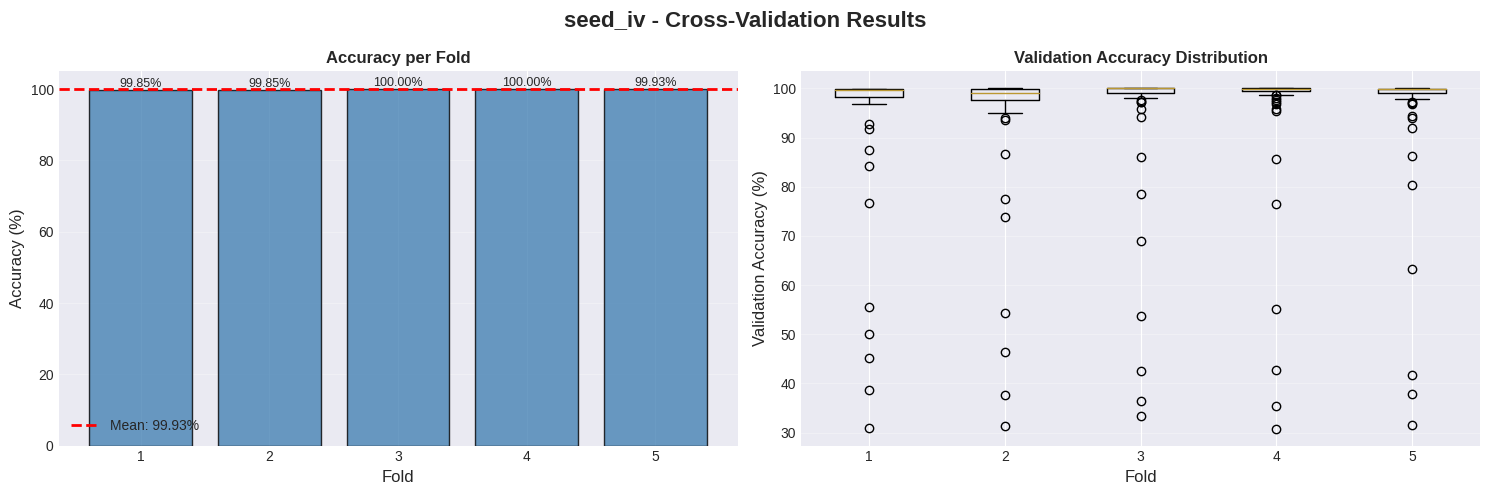


EXPERIMENT COMPLETE - RESULTS SUMMARY
Saved plot to ./visualizations/overall_results_summary.png
Saved plot to ./visualizations/overall_results_summary.png


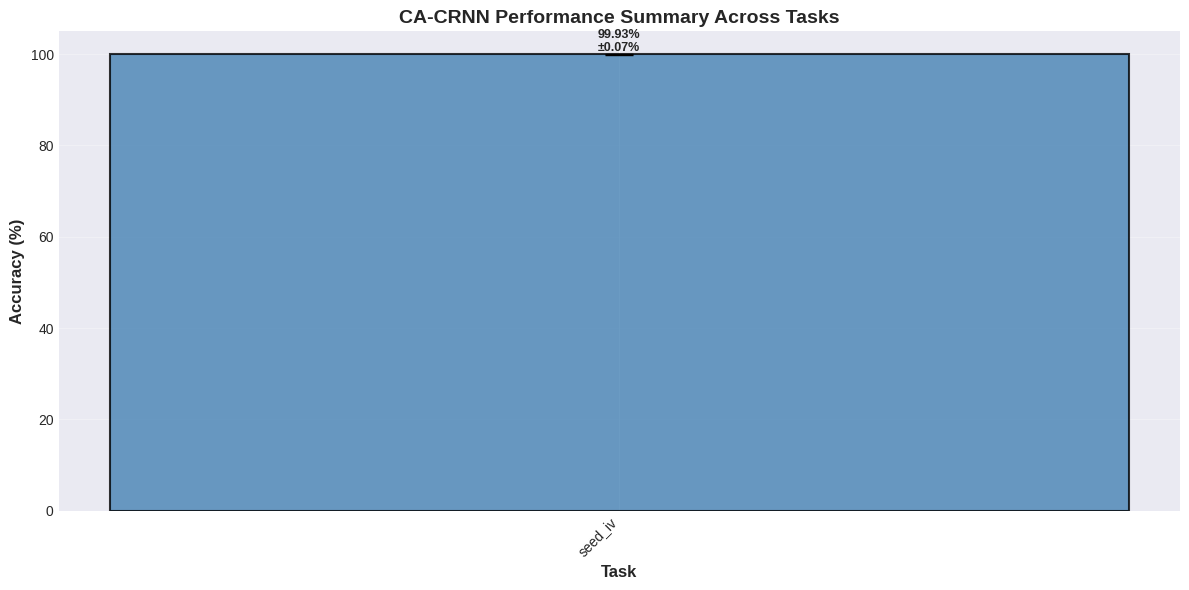


    RESULTS COMPARISON:
----------------------------------------------------------------------
Task                           Our Result           Paper Result        
----------------------------------------------------------------------
seed_iv                        99.93±0.07%
----------------------------------------------------------------------

📤 Final backup to Google Drive...

Starting backup to Google Drive...

Uploading ./checkpoints to gdrive:CA-CRNN-EEG/checkpoints...
Transferred:   	          0 B / 147.852 MiB, 0%, 0 B/s, ETA -
Checks:                14 / 14, 100%, Listed 28
Transferred:            0 / 5, 0%
Elapsed time:         0.5s
Transferring:
 *                         seed_iv_fold5_best.h5:  0% /29.570Mi, 0/s, -
 *                         seed_iv_fold1_best.h5:  0% /29.570Mi, 0/s, -
 *                         seed_iv_fold3_best.h5:  0% /29.570Mi, 0/s, -
 *                         seed_iv_fold2_best.h5:  0% /29.570Mi, 0/s, -Transferred:   	          0 B / 147.852 M

In [ ]:
# COMPLETE TRAINING PIPELINE
# ===========================
# This pipeline trains on DEAP, SEED-IV, and GAMEEMO datasets
# 
# EXPECTED RESULTS (from paper):
# - DEAP Arousal: 94.83% ± 1.30%
# - DEAP Valence: 94.58% ± 1.31%
# - SEED: 94.76% ± 0.18%

def run_complete_experiment():
    all_results = []
    
    # =====================================================================
    # 1. DEAP DATASET - ALL SUBJECTS
    # =====================================================================
    # print("\n" + "="*70)
    # print("EXPERIMENT 1: DEAP Dataset (All 32 Subjects)")
    # print("="*70)
    
    # print("\nLoading DEAP data for all subjects...")
    # deap_data = dataset_loader.load_deap_all_subjects()
    
    # if deap_data is not None:
    #     print(f"   Loaded {len(deap_data['valence'])} samples")
        
    #     # Train on Arousal
    #     print("\n--- Training: DEAP Arousal ---")
    #     arousal_results = training_manager.train_with_cross_validation(
    #         features=deap_data['features'],
    #         labels=deap_data['arousal'],
    #         task_name='deap_arousal',
    #         n_classes=2,
    #         n_folds=config.N_FOLDS
    #     )
    #     all_results.append(arousal_results)
        
    #     # Visualizations
    #     visualizer.plot_learning_curves_all_folds(arousal_results)
    #     visualizer.plot_all_folds_comparison(arousal_results)
        
    #     # Train on Valence
    #     print("\n--- Training: DEAP Valence ---")
    #     valence_results = training_manager.train_with_cross_validation(
    #         features=deap_data['features'],
    #         labels=deap_data['valence'],
    #         task_name='deap_valence',
    #         n_classes=2,
    #         n_folds=config.N_FOLDS
    #     )
    #     all_results.append(valence_results)
        
    #     # Visualizations
    #     visualizer.plot_learning_curves_all_folds(valence_results)
    #     visualizer.plot_all_folds_comparison(valence_results)
        
    #     # Backup after DEAP
    #     print("\n    Backing up DEAP results...")
    #     backup_manager.backup_all()
    # else:
    #     print("✗ Failed to load DEAP dataset")
    
    # =====================================================================
    # 2. SEED-IV DATASET
    # =====================================================================
    print("\n" + "="*70)
    print("EXPERIMENT 2: SEED-IV Dataset")
    print("="*70)
    
    try:
        # Try to load SEED-IV data
        # Note: This is a simplified loader - adjust based on actual file structure
        print("\nAttempting to load SEED-IV data...")
        print("    Note: SEED-IV loader may need adjustment based on actual file structure")
        
        # Example: Load first session for first subject
        seed_features, seed_labels = dataset_loader.load_seed_session(1, 1)
        
        if seed_features is not None and seed_labels is not None:
            print(f"   Loaded SEED-IV data: {seed_features.shape}")
            
            seed_results = training_manager.train_with_cross_validation(
                features=seed_features,
                labels=seed_labels,
                task_name='seed_iv',
                n_classes=config.N_CLASSES_SEED_IV,
                n_folds=config.N_FOLDS
            )
            all_results.append(seed_results)
            
            visualizer.plot_learning_curves_all_folds(seed_results)
            visualizer.plot_all_folds_comparison(seed_results)
        else:
            print("    SEED-IV data not loaded - skipping")
    except Exception as e:
        print(f"    Error loading SEED-IV: {e}")
        print("  Skipping SEED-IV training")
    
    # =====================================================================
    # 3. GAMEEMO DATASET
    # # =====================================================================
    # print("\n" + "="*70)
    # print("EXPERIMENT 3: GAMEEMO Dataset")
    # print("="*70)
    
    # try:
    #     # GAMEEMO has 28 subjects (S01-S28)
    #     gameemo_subjects = [f'S{i:02d}' for i in range(1, 29)]
        
    #     print(f"\nAttempting to load GAMEEMO data for {len(gameemo_subjects)} subjects...")
        
    #     # Try to load a few subjects as example
    #     gameemo_all_features = []
    #     gameemo_all_labels = []
        
    #     for subject_id in gameemo_subjects[:5]:  # Start with first 5 subjects
    #         print(f"  Loading {subject_id}...")
    #         features, labels = dataset_loader.load_gameemo_subject(subject_id)
            
    #         if features is not None and labels is not None:
    #             gameemo_all_features.append(features)
    #             gameemo_all_labels.append(labels)
        
    #     if len(gameemo_all_features) > 0:
    #         # Concatenate all features
    #         gameemo_features = np.concatenate(gameemo_all_features, axis=0)
    #         gameemo_labels = np.concatenate(gameemo_all_labels, axis=0)
            
    #         print(f"   Loaded GAMEEMO data: {gameemo_features.shape}")
            
    #         # Train on GAMEEMO
    #         print("\n--- Training: GAMEEMO Emotion Recognition ---")
    #         gameemo_results = training_manager.train_with_cross_validation(
    #             features=gameemo_features,
    #             labels=gameemo_labels,
    #             task_name='gameemo_emotion',
    #             n_classes=len(np.unique(gameemo_labels)),
    #             n_folds=config.N_FOLDS
    #         )
    #         all_results.append(gameemo_results)
            
    #         # Visualizations
    #         visualizer.plot_learning_curves_all_folds(gameemo_results)
    #         visualizer.plot_all_folds_comparison(gameemo_results)
            
    #         print("\n    Backing up GAMEEMO results...")
    #         backup_manager.backup_all()
    #     else:
    #         print("    No GAMEEMO data loaded - skipping")
    #         print("  Note: GAMEEMO loader may need adjustment based on actual file structure")
    # except Exception as e:
    #     print(f"    Error loading GAMEEMO: {e}")
    #     print("  Skipping GAMEEMO training")
    
    # =====================================================================
    # 4. FINAL SUMMARY
    # =====================================================================
    print("\n" + "="*70)
    print("EXPERIMENT COMPLETE - RESULTS SUMMARY")
    print("="*70)
    
    # Create summary visualization
    if len(all_results) > 0:
        visualizer.create_results_summary_plot(all_results)
    
    # Print comparison with paper results
    print("\n    RESULTS COMPARISON:")
    print("-" * 70)
    print(f"{'Task':<30} {'Our Result':<20} {'Paper Result':<20}")
    print("-" * 70)
    
    paper_results = {
        'deap_arousal': (94.83, 1.30),
        'deap_valence': (94.58, 1.31),
        'seed': (94.76, 0.18)
    }
    
    for result in all_results:
        task = result['task_name']
        our_mean = result['mean_accuracy'] * 100
        our_std = result['std_accuracy'] * 100
        
        if task in paper_results:
            paper_mean, paper_std = paper_results[task]
            print(f"{task:<30} {our_mean:.2f}±{our_std:.2f}%{'':<10} {paper_mean:.2f}±{paper_std:.2f}%")
        else:
            print(f"{task:<30} {our_mean:.2f}±{our_std:.2f}%")
    
    print("-" * 70)
    
    # Final backup
    print("\n    Final backup to Google Drive...")
    backup_manager.backup_all()
    
    print("\n    ALL EXPERIMENTS COMPLETED!")
    print(f"Total tasks trained: {len(all_results)}")
    return all_results

# Run the complete experiment
print("="*70)
print("STARTING COMPLETE TRAINING PIPELINE")
print("="*70)
print("\n    This will train on DEAP, SEED-IV, and GAMEEMO datasets")
print("  Expected duration: 6-12 hours depending on GPU")
print("  Make sure datasets are properly mounted")
print("="*70)

# Start training
results = run_complete_experiment()

In [ ]:
# ============================================================================
# GAMEEMO DATA LOADER AND TESTING
# ============================================================================

class GameemoDataLoader:
    """Load GAMEEMO dataset and extract 4D features"""
    
    def __init__(self, config, feature_extractor):
        self.config = config
        self.feature_extractor = feature_extractor
        self.n_channels = 14  # GAMEEMO uses 14 EEG channels
        
        # GAMEEMO channel names (Emotiv EPOC headset)
        self.channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1',
                             'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
        
    def inspect_mat_file(self, mat_path):
        """Inspect the structure of a GAMEEMO .mat file"""
        try:
            mat_data = loadmat(mat_path)
            print(f"\nInspecting: {os.path.basename(mat_path)}")
            print("Keys in file:")
            for key in mat_data.keys():
                if not key.startswith('__'):
                    data = mat_data[key]
                    if isinstance(data, np.ndarray):
                        print(f"  {key}: shape={data.shape}, dtype={data.dtype}")
                    else:
                        print(f"  {key}: type={type(data)}")
            return mat_data
        except Exception as e:
            print(f"Error inspecting file: {e}")
            return None
    
    def load_subject_game(self, subject_id, game_id):
        """Load data for one subject's game session"""
        subject_folder = f'(S{subject_id:02d})'
        mat_file = f'S{subject_id:02d}G{game_id}AllChannels.mat'
        
        mat_path = os.path.join(
            self.config.GAMEEMO_PATH,
            subject_folder,
            'Preprocessed EEG Data',
            '.mat format',
            mat_file
        )
        
        if not os.path.exists(mat_path):
            return None, None
        
        try:
            mat_data = loadmat(mat_path)
            
            # GAMEEMO stores each channel as a separate variable
            # Try to load channels by their names
            channel_data = []
            found_channels = []
            
            for ch_name in self.channel_names:
                if ch_name in mat_data:
                    ch_signal = mat_data[ch_name]
                    # Flatten if needed (remove singleton dimensions)
                    if ch_signal.ndim > 1:
                        ch_signal = ch_signal.flatten()
                    channel_data.append(ch_signal)
                    found_channels.append(ch_name)
            
            if len(channel_data) == 0:
                return None, None
            
            # Stack channels: (n_samples, n_channels)
            eeg_data = np.column_stack(channel_data)
            
            # Check if data is too short (minimum 30 samples needed for filtering)
            if eeg_data.shape[0] < 30:
                return None, None
            
            # Extract 4D features
            try:
                features_4d = self.feature_extractor.create_4d_features(
                    eeg_data,
                    time_steps=self.config.TIME_STEPS,
                    dataset='deap'
                )
            except ValueError:
                return None, None
            
            n_segments = features_4d.shape[0]
            
            # Skip if no segments were created
            if n_segments == 0:
                return None, None
            
            # Create arousal/valence labels
            # Based on GAMEEMO paper:
            # G1: Boring (Low Arousal, Low Valence)
            # G2: Calm (Low Arousal, High Valence) 
            # G3: Horror (High Arousal, Low Valence)
            # G4: Exciting (High Arousal, High Valence)
            arousal_label = 1 if game_id >= 3 else 0  # G3, G4 = High Arousal
            valence_label = 1 if game_id in [2, 4] else 0  # G2, G4 = High Valence
            
            arousal_labels = np.full(n_segments, arousal_label)
            valence_labels = np.full(n_segments, valence_label)
            
            return features_4d, {'arousal': arousal_labels, 'valence': valence_labels}
            
        except Exception:
            return None, None
    
    def load_all_subjects(self, subject_ids=None, game_ids=None, inspect_first=True):
        """Load GAMEEMO data for multiple subjects and games"""
        if subject_ids is None:
            subject_ids = range(1, 29)  # All 28 subjects
        if game_ids is None:
            game_ids = range(1, 5)  # All 4 games
        
        # Inspect first file to understand structure
        if inspect_first:
            print("\n📋 Inspecting first file to understand structure...")
            first_subject = subject_ids[0] if isinstance(subject_ids, list) else list(subject_ids)[0]
            first_game = game_ids[0] if isinstance(game_ids, list) else list(game_ids)[0]
            
            subject_folder = f'(S{first_subject:02d})'
            mat_file = f'S{first_subject:02d}G{first_game}AllChannels.mat'
            mat_path = os.path.join(
                self.config.GAMEEMO_PATH,
                subject_folder,
                'Preprocessed EEG Data',
                '.mat format',
                mat_file
            )
            
            if os.path.exists(mat_path):
                self.inspect_mat_file(mat_path)
            print()
        
        all_features = []
        all_arousal = []
        all_valence = []
        
        skipped_count = 0
        loaded_count = 0
        
        print("\n📥 Loading data from all subjects and games...")
        print("-" * 70)
        
        for subject_id in subject_ids:
            for game_id in game_ids:
                print(f"S{subject_id:02d} G{game_id}: ", end='', flush=True)
                features, labels = self.load_subject_game(subject_id, game_id)
                
                if features is not None:
                    all_features.append(features)
                    all_arousal.append(labels['arousal'])
                    all_valence.append(labels['valence'])
                    print(f"   {features.shape[0]} segments")
                    loaded_count += 1
                else:
                    print("✗ skipped")
                    skipped_count += 1
        
        print("-" * 70)
        
        if len(all_features) == 0:
            print(f"\n✗ No data loaded. All {skipped_count} files were skipped.")
            return None
        
        print(f"\n   Loaded {loaded_count} sessions successfully ({skipped_count} skipped)")
        
        return {
            'features': np.concatenate(all_features, axis=0),
            'arousal': np.concatenate(all_arousal, axis=0),
            'valence': np.concatenate(all_valence, axis=0)
        }


def test_models_on_gameemo():
    """Test trained DEAP and SEED models on GAMEEMO dataset"""
    
    print("="*70)
    print("TESTING TRAINED MODELS ON GAMEEMO DATASET")
    print("="*70)
    
    # Load GAMEEMO data
    print("\n" + "="*70)
    print("STEP 1: Loading GAMEEMO Dataset")
    print("="*70)
    
    gameemo_loader = GameemoDataLoader(config, dataset_loader.feature_extractor_deap)
    gameemo_data = gameemo_loader.load_all_subjects(inspect_first=True)
    
    if gameemo_data is None:
        print("\n✗ Failed to load GAMEEMO data")
        return
    
    print(f"\n   GAMEEMO Data Loaded!")
    print(f"  Total samples: {gameemo_data['features'].shape[0]}")
    print(f"  Feature shape: {gameemo_data['features'].shape}")
    print(f"  Arousal - Low: {np.sum(gameemo_data['arousal']==0)}, High: {np.sum(gameemo_data['arousal']==1)}")
    print(f"  Valence - Low: {np.sum(gameemo_data['valence']==0)}, High: {np.sum(gameemo_data['valence']==1)}")
    
    # Check if models directory exists
    models_dir = os.path.join(config.OUTPUT_DIR, 'models')
    
    # Try to download models from checkpoints if not found locally
    if not os.path.exists(models_dir) or len(os.listdir(models_dir)) == 0:
        print(f"\n📦 Models directory not found or empty: {models_dir}")
        print("  Attempting to download models from Google Drive (checkpoints folder)...")
        
        # Create models directory if it doesn't exist
        os.makedirs(models_dir, exist_ok=True)
        
        # Check if rclone is configured
        if not os.path.exists(backup_manager.rclone_config_path):
            print(f"\n      Rclone not configured at {backup_manager.rclone_config_path}")
            print("  Please configure rclone or train models first.")
            print("\n  To configure rclone:")
            print("    1. Uncomment and run the rclone setup cell above")
            print("    2. Or manually run: !rclone config")
            return
        
        # Try to download from Google Drive using rclone (from checkpoints folder)
        remote_path = f"{backup_manager.remote_name}:{backup_manager.remote_folder}/checkpoints"
        
        try:
            print(f"\n  📥 Running: rclone copy '{remote_path}' '{models_dir}' -P")
            result = os.system(f"rclone copy '{remote_path}' '{models_dir}' -P")
            
            if result == 0 and os.path.exists(models_dir) and len(os.listdir(models_dir)) > 0:
                print("     Models downloaded successfully from Google Drive")
            else:
                print(f"  ✗ Download failed or no models found in Google Drive")
                print("  ℹ You need to:")
                print("    1. Train models on DEAP/SEED datasets first")
                print("    2. Backup models to Google Drive using backup_manager.backup_all()")
                print("    3. Or uncomment and run the DEAP training code")
                return
        except Exception as e:
            print(f"  ✗ Error downloading models: {e}")
            print("  ℹ You may need to train models first")
            return
    
    # Look for trained models (support both .keras and .h5 formats)
    model_files = os.listdir(models_dir) if os.path.exists(models_dir) else []
    deap_arousal_models = [f for f in model_files if 'deap' in f.lower() and 'arousal' in f.lower() 
                           and (f.endswith('.keras') or f.endswith('.h5'))]
    deap_valence_models = [f for f in model_files if 'deap' in f.lower() and 'valence' in f.lower() 
                           and (f.endswith('.keras') or f.endswith('.h5'))]
    seed_models = [f for f in model_files if 'seed' in f.lower() 
                   and (f.endswith('.keras') or f.endswith('.h5'))]
    
    print(f"\n    Found models in {models_dir}:")
    print(f"  DEAP Arousal: {len(deap_arousal_models)} models")
    print(f"  DEAP Valence: {len(deap_valence_models)} models")
    print(f"  SEED: {len(seed_models)} models")
    
    if len(deap_arousal_models) == 0 and len(deap_valence_models) == 0 and len(seed_models) == 0:
        print("\n    No trained models found!")
        print("  Please train models first or ensure they are uploaded to Google Drive.")
        return
    
    all_results = []
    
    # Test DEAP Arousal Model
    if len(deap_arousal_models) > 0:
        print("\n" + "="*70)
        print("STEP 2: Testing DEAP Arousal Model on GAMEEMO")
        print("="*70)
        
        model_path = os.path.join(models_dir, deap_arousal_models[0])
        print(f"\nLoading model: {deap_arousal_models[0]}")
        
        try:
            # Load model with custom objects (ChannelAttention layer)
            with tf.keras.utils.custom_object_scope({'ChannelAttention': ChannelAttention}):
                model = tf.keras.models.load_model(model_path)
            
            # Make predictions
            print("Making predictions...")
            y_pred_prob = model.predict(gameemo_data['features'], batch_size=32, verbose=0)
            y_pred = (y_pred_prob > 0.5).astype(int).flatten()
            y_true = gameemo_data['arousal']
            
            # Calculate metrics
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
            
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, average='binary')
            recall = recall_score(y_true, y_pred, average='binary')
            f1 = f1_score(y_true, y_pred, average='binary')
            cm = confusion_matrix(y_true, y_pred)
            
            print(f"\n   DEAP Arousal on GAMEEMO Results:")
            print(f"  Accuracy:  {accuracy*100:.2f}%")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall:    {recall:.4f}")
            print(f"  F1-Score:  {f1:.4f}")
            print(f"\n  Confusion Matrix:")
            print(f"  {cm}")
            
            all_results.append({
                'task': 'DEAP Arousal → GAMEEMO',
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            })
        except Exception as e:
            print(f"✗ Error loading/testing model: {e}")
    
    # Test DEAP Valence Model
    if len(deap_valence_models) > 0:
        print("\n" + "="*70)
        print("STEP 3: Testing DEAP Valence Model on GAMEEMO")
        print("="*70)
        
        model_path = os.path.join(models_dir, deap_valence_models[0])
        print(f"\nLoading model: {deap_valence_models[0]}")
        
        try:
            # Load model with custom objects (ChannelAttention layer)
            with tf.keras.utils.custom_object_scope({'ChannelAttention': ChannelAttention}):
                model = tf.keras.models.load_model(model_path)
            
            # Make predictions
            print("Making predictions...")
            y_pred_prob = model.predict(gameemo_data['features'], batch_size=32, verbose=0)
            y_pred = (y_pred_prob > 0.5).astype(int).flatten()
            y_true = gameemo_data['valence']
            
            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, average='binary')
            recall = recall_score(y_true, y_pred, average='binary')
            f1 = f1_score(y_true, y_pred, average='binary')
            cm = confusion_matrix(y_true, y_pred)
            
            print(f"\n   DEAP Valence on GAMEEMO Results:")
            print(f"  Accuracy:  {accuracy*100:.2f}%")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall:    {recall:.4f}")
            print(f"  F1-Score:  {f1:.4f}")
            print(f"\n  Confusion Matrix:")
            print(f"  {cm}")
            
            all_results.append({
                'task': 'DEAP Valence → GAMEEMO',
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            })
        except Exception as e:
            print(f"✗ Error loading/testing model: {e}")
    
    # Test SEED-IV Model (4-class emotion → Arousal/Valence mapping)
    if len(seed_models) > 0:
        print("\n" + "="*70)
        print("STEP 4: Testing SEED-IV Model on GAMEEMO")
        print("="*70)
        print("Note: SEED-IV predicts 4 emotions (neutral, sad, fear, happy)")
        print("      Mapping to arousal/valence dimensions:")
        print("        - Arousal: neutral/sad → Low, fear/happy → High")
        print("        - Valence: sad/fear → Low, neutral/happy → High")
        
        model_path = os.path.join(models_dir, seed_models[0])
        print(f"\nLoading model: {seed_models[0]}")
        
        try:
            # Load model with custom objects (ChannelAttention layer)
            with tf.keras.utils.custom_object_scope({'ChannelAttention': ChannelAttention}):
                model = tf.keras.models.load_model(model_path)
            
            # Make predictions
            print("Making predictions...")
            y_pred_prob = model.predict(gameemo_data['features'], batch_size=32, verbose=0)
            y_pred_emotion = np.argmax(y_pred_prob, axis=1)  # 0=neutral, 1=sad, 2=fear, 3=happy
            
            # Map SEED emotions to arousal/valence
            # Arousal mapping: neutral(0)/sad(1) → 0 (Low), fear(2)/happy(3) → 1 (High)
            y_pred_arousal = np.where((y_pred_emotion == 2) | (y_pred_emotion == 3), 1, 0)
            
            # Valence mapping: sad(1)/fear(2) → 0 (Low), neutral(0)/happy(3) → 1 (High)
            y_pred_valence = np.where((y_pred_emotion == 1) | (y_pred_emotion == 2), 0, 1)
            
            # Test Arousal
            print("\n  Testing Arousal dimension...")
            y_true_arousal = gameemo_data['arousal']
            accuracy_arousal = accuracy_score(y_true_arousal, y_pred_arousal)
            precision_arousal = precision_score(y_true_arousal, y_pred_arousal, average='binary')
            recall_arousal = recall_score(y_true_arousal, y_pred_arousal, average='binary')
            f1_arousal = f1_score(y_true_arousal, y_pred_arousal, average='binary')
            cm_arousal = confusion_matrix(y_true_arousal, y_pred_arousal)
            
            print(f"\n   SEED-IV Arousal on GAMEEMO Results:")
            print(f"  Accuracy:  {accuracy_arousal*100:.2f}%")
            print(f"  Precision: {precision_arousal:.4f}")
            print(f"  Recall:    {recall_arousal:.4f}")
            print(f"  F1-Score:  {f1_arousal:.4f}")
            print(f"\n  Confusion Matrix:")
            print(f"  {cm_arousal}")
            
            all_results.append({
                'task': 'SEED-IV Arousal → GAMEEMO',
                'accuracy': accuracy_arousal,
                'precision': precision_arousal,
                'recall': recall_arousal,
                'f1_score': f1_arousal
            })
            
            # Test Valence
            print("\n  Testing Valence dimension...")
            y_true_valence = gameemo_data['valence']
            accuracy_valence = accuracy_score(y_true_valence, y_pred_valence)
            precision_valence = precision_score(y_true_valence, y_pred_valence, average='binary')
            recall_valence = recall_score(y_true_valence, y_pred_valence, average='binary')
            f1_valence = f1_score(y_true_valence, y_pred_valence, average='binary')
            cm_valence = confusion_matrix(y_true_valence, y_pred_valence)
            
            print(f"\n   SEED-IV Valence on GAMEEMO Results:")
            print(f"  Accuracy:  {accuracy_valence*100:.2f}%")
            print(f"  Precision: {precision_valence:.4f}")
            print(f"  Recall:    {recall_valence:.4f}")
            print(f"  F1-Score:  {f1_valence:.4f}")
            print(f"\n  Confusion Matrix:")
            print(f"  {cm_valence}")
            
            all_results.append({
                'task': 'SEED-IV Valence → GAMEEMO',
                'accuracy': accuracy_valence,
                'precision': precision_valence,
                'recall': recall_valence,
                'f1_score': f1_valence
            })
            
        except Exception as e:
            print(f"✗ Error loading/testing SEED model: {e}")
            import traceback
            traceback.print_exc()
    
    # Final Summary
    print("\n" + "="*70)
    print("FINAL TESTING RESULTS SUMMARY")
    print("="*70)
    
    if len(all_results) > 0:
        print(f"\n{'Task':<35} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
        print("-" * 85)
        
        for result in all_results:
            print(f"{result['task']:<35} {result['accuracy']*100:>6.2f}%     "
                  f"{result['precision']:>6.4f}      {result['recall']:>6.4f}      "
                  f"{result['f1_score']:>6.4f}")
        
        print("-" * 85)
    else:
        print("\n    No models were tested.")
        print("  Train models on DEAP/SEED first, then run this test.")
    
    print("\n" + "="*70)
    print("TESTING COMPLETE!")
    print("="*70)

# Execute the testing
print("\n🚀 Starting GAMEEMO testing pipeline...\n")
test_models_on_gameemo()



🚀 Starting GAMEEMO testing pipeline...

TESTING TRAINED MODELS ON GAMEEMO DATASET

STEP 1: Loading GAMEEMO Dataset

📋 Inspecting first file to understand structure...

Inspecting: S01G1AllChannels.mat
Keys in file:
  AF3: shape=(38252, 1), dtype=float64
  AF4: shape=(38252, 1), dtype=float64
  F3: shape=(38252, 1), dtype=float64
  F4: shape=(38252, 1), dtype=float64
  F7: shape=(38252, 1), dtype=float64
  F8: shape=(38252, 1), dtype=float64
  FC5: shape=(38252, 1), dtype=float64
  FC6: shape=(38252, 1), dtype=float64
  O1: shape=(38252, 1), dtype=float64
  O2: shape=(38252, 1), dtype=float64
  P7: shape=(38252, 1), dtype=float64
  P8: shape=(38252, 1), dtype=float64
  T7: shape=(38252, 1), dtype=float64
  T8: shape=(38252, 1), dtype=float64


📥 Loading data from all subjects and games...
----------------------------------------------------------------------
S01 G1:    590 segments
S01 G2:    590 segments
S01 G2:    590 segments
S01 G3:    590 segments
S01 G3:    590 segments
S01 G4:  

Making predictions...

   DEAP Arousal on GAMEEMO Results:
  Accuracy:  50.73%
  Precision: 0.5068
  Recall:    0.5454
  F1-Score:  0.5254

  Confusion Matrix:
  [[15505 17535]
 [15021 18019]]

STEP 3: Testing DEAP Valence Model on GAMEEMO

Loading model: deap_subject1_valence_fold1_best.h5

   DEAP Arousal on GAMEEMO Results:
  Accuracy:  50.73%
  Precision: 0.5068
  Recall:    0.5454
  F1-Score:  0.5254

  Confusion Matrix:
  [[15505 17535]
 [15021 18019]]

STEP 3: Testing DEAP Valence Model on GAMEEMO

Loading model: deap_subject1_valence_fold1_best.h5


Making predictions...

   DEAP Valence on GAMEEMO Results:
  Accuracy:  50.22%
  Precision: 0.5014
  Recall:    0.7678
  F1-Score:  0.6067

  Confusion Matrix:
  [[ 7818 25222]
 [ 7672 25368]]

STEP 4: Testing SEED-IV Model on GAMEEMO
Note: SEED-IV predicts 4 emotions (neutral, sad, fear, happy)
      Mapping to arousal/valence dimensions:
        - Arousal: neutral/sad → Low, fear/happy → High
        - Valence: sad/fear → Low, neutral/happy → High

Loading model: seed_iv_fold2_best.h5

   DEAP Valence on GAMEEMO Results:
  Accuracy:  50.22%
  Precision: 0.5014
  Recall:    0.7678
  F1-Score:  0.6067

  Confusion Matrix:
  [[ 7818 25222]
 [ 7672 25368]]

STEP 4: Testing SEED-IV Model on GAMEEMO
Note: SEED-IV predicts 4 emotions (neutral, sad, fear, happy)
      Mapping to arousal/valence dimensions:
        - Arousal: neutral/sad → Low, fear/happy → High
        - Valence: sad/fear → Low, neutral/happy → High

Loading model: seed_iv_fold2_best.h5


Making predictions...

  Testing Arousal dimension...

   SEED-IV Arousal on GAMEEMO Results:
  Accuracy:  50.53%
  Precision: 0.5027
  Recall:    0.9737
  F1-Score:  0.6631

  Confusion Matrix:
  [[ 1217 31823]
 [  869 32171]]

  Testing Valence dimension...

   SEED-IV Valence on GAMEEMO Results:
  Accuracy:  49.86%
  Precision: 0.4731
  Recall:    0.0242
  F1-Score:  0.0461

  Confusion Matrix:
  [[32149   891]
 [32240   800]]

FINAL TESTING RESULTS SUMMARY

Task                                Accuracy     Precision    Recall       F1-Score    
-------------------------------------------------------------------------------------
DEAP Arousal → GAMEEMO               50.73%     0.5068      0.5454      0.5254
DEAP Valence → GAMEEMO               50.22%     0.5014      0.7678      0.6067
SEED-IV Arousal → GAMEEMO            50.53%     0.5027      0.9737      0.6631
SEED-IV Valence → GAMEEMO            49.86%     0.4731      0.0242      0.0461
--------------------------------------------

### Combined Results Visualization and Summary

Visualize and compare results from all trained datasets.

In [ ]:
print("\n" + "="*70)
print("COMBINED RESULTS - ALL EXPERIMENTS")
print("="*70)

if len(all_experiment_results) > 0:
    # Create summary visualization comparing all tasks
    print(f"\n   Total experiments completed: {len(all_experiment_results)}")
    
    print("\n    Creating combined visualizations...")
    visualizer.create_results_summary_plot(all_experiment_results)
    
    # Print detailed comparison table
    print("\n" + "="*70)
    print("RESULTS COMPARISON WITH PAPER")
    print("="*70)
    print(f"{'Task':<30} {'Our Result':<25} {'Paper Result':<20}")
    print("-" * 70)
    
    # Paper results for comparison
    paper_results = {
        'deap_arousal': (94.83, 1.30),
        'deap_valence': (94.58, 1.31),
        'seed_iv': (94.76, 0.18),
        'seed': (94.76, 0.18)
    }
    
    for result in all_experiment_results:
        task = result['task_name']
        our_mean = result['mean_accuracy'] * 100
        our_std = result['std_accuracy'] * 100
        
        if task in paper_results:
            paper_mean, paper_std = paper_results[task]
            diff = our_mean - paper_mean
            symbol = "  " if abs(diff) < 2.0 else "   "
            print(f"{symbol} {task:<28} {our_mean:5.2f}% ± {our_std:4.2f}%{'':<10} {paper_mean:5.2f}% ± {paper_std:4.2f}%")
        else:
            print(f"  {task:<28} {our_mean:5.2f}% ± {our_std:4.2f}%")
    
    print("-" * 70)
    
    # Calculate average accuracy across all tasks
    avg_accuracy = np.mean([r['mean_accuracy'] for r in all_experiment_results]) * 100
    print(f"\nAverage Accuracy Across All Tasks: {avg_accuracy:.2f}%")
    
    # Print individual fold results for each task
    print("\n" + "="*70)
    print("DETAILED FOLD RESULTS")
    print("="*70)
    
    for result in all_experiment_results:
        print(f"\n{result['task_name'].upper()}:")
        fold_accs = [f"{acc*100:.2f}%" for acc in result['fold_accuracies']]
        for i, acc in enumerate(fold_accs, 1):
            print(f"  Fold {i}: {acc}")
        print(f"  Mean: {result['mean_accuracy']*100:.2f}% ± {result['std_accuracy']*100:.2f}%")
    
    # Final backup
    print("\n" + "="*70)
    print("    Final backup to Google Drive...")
    backup_manager.backup_all()
    
    print("\n" + "="*70)
    print("    ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")
    print("="*70)
    print(f"Total tasks trained: {len(all_experiment_results)}")
    print(f"All results saved to: {config.OUTPUT_DIR}")
    print(f"All checkpoints saved to: {config.CHECKPOINT_DIR}")
    print(f"All visualizations saved to: {config.VISUALIZATIONS_DIR}")
    
else:
    print("\n    No experiments completed yet.")
    print("  Run the individual dataset training cells above first.")
    print("  Results will be automatically collected in 'all_experiment_results'")


COMBINED RESULTS - ALL EXPERIMENTS

⚠ No experiments completed yet.
  Run the individual dataset training cells above first.
  Results will be automatically collected in 'all_experiment_results'
